#  ESG + Machine Reasoning + Causal A
This notebook implements the complete end-to-end pipeline:
 - Data profiling
 - Preprocessing
 - Baseline ML models
 - Machine Reasoning layer (Rule + Causal + Graph)
 - Fusion model
 - Explainability (SHAP)
 - Fairness analysis
 - Counterfactual simulations
 - Results & Discussion



 ---



In [1]:
# %%
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# Utils from your project
import data_utils as du
import feature_engineering_updated as fe
import model_utils as mu
import mr_utils_updated as mru
import shap_utils as su

print("Environment loaded successfully.")


c:\Users\HOSEO\anaconda3\envs\esgmr\lib\site-packages\node2vec\edges.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Environment loaded successfully.


In [2]:
# %%
file_path = r"D:\ESG research work\global conference\company_esg_financial_dataset (1).csv"
df = pd.read_csv(file_path)

print(f"Loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns.")
df.head()


Loaded dataset with 11000 rows and 16 columns.


CompanyID CompanyName Industry         Region  Year  Revenue  ProfitMargin  \
0          1   Company_1   Retail  Latin America  2015    459.2           6.0   
1          1   Company_1   Retail  Latin America  2016    473.8           4.6   
2          1   Company_1   Retail  Latin America  2017    564.9           5.2   
3          1   Company_1   Retail  Latin America  2018    558.4           4.3   
4          1   Company_1   Retail  Latin America  2019    554.5           4.9   

   MarketCap  GrowthRate  ESG_Overall  ESG_Environmental  ESG_Social  \
0      337.5         NaN         57.0               60.7        33.5   
1      366.6         3.2         56.7               58.9        32.8   
2      313.4        19.2         56.5               57.6        34.0   
3      283.0        -1.1         58.0               62.3        33.4   
4      538.1        -0.7         56.6               63.7        30.0   

   ESG_Governance  CarbonEmissions  WaterUsage  EnergyConsumption  
0            76.8          35577.4     17788.7            71154.7  
1            78.5          37314.7     18657.4            74629.4  
2            77.8          45006.4     22503.2            90012.9  
3            78.3          42650.1     21325.1            85300.2  
4            76.1          41799.4     20899.7            83598.8

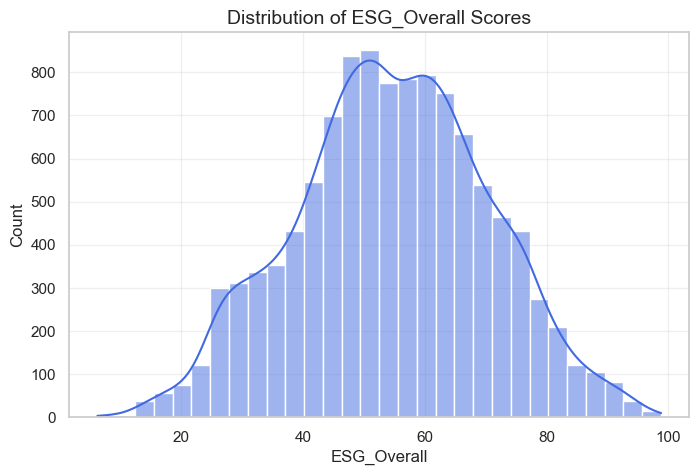

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df["ESG_Overall"], bins=30, kde=True, color="royalblue")
plt.title("Distribution of ESG_Overall Scores", fontsize=14)
plt.xlabel("ESG_Overall")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.show()


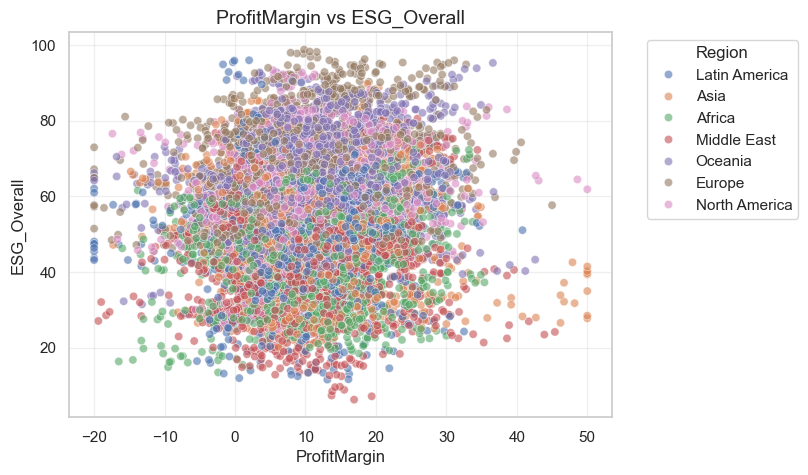

In [83]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df,
    x="ProfitMargin",
    y="ESG_Overall",
    hue="Region",
    alpha=0.6
)
plt.title("ProfitMargin vs ESG_Overall", fontsize=14)
plt.xlabel("ProfitMargin")
plt.ylabel("ESG_Overall")
plt.grid(alpha=0.3)
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


<Axes: xlabel='ProfitMargin', ylabel='ESG_Overall'>

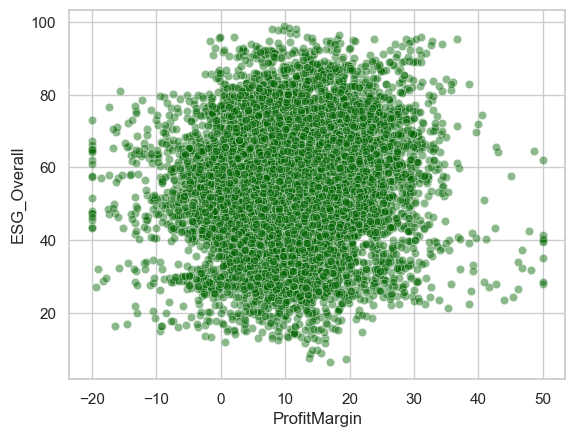

In [84]:
sns.scatterplot(df, x="ProfitMargin", y="ESG_Overall", alpha=0.45, color="darkgreen")


C:\Users\HOSEO\AppData\Local\Temp\ipykernel_69852\3435446023.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=region_esg.index, y=region_esg.values, palette="viridis")


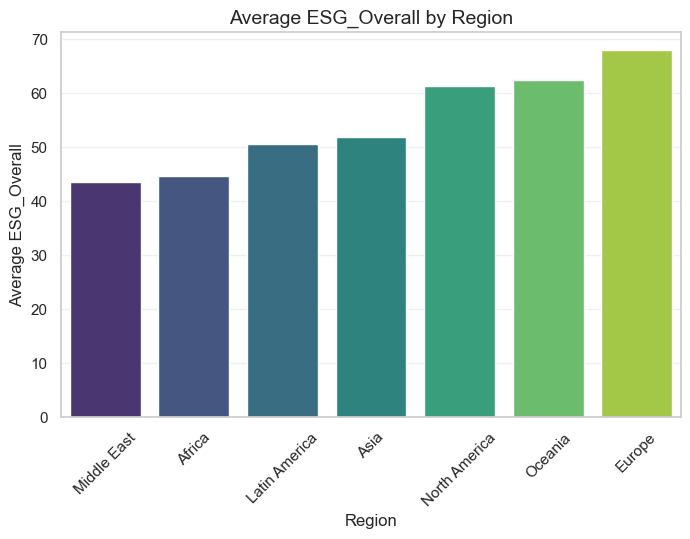

In [75]:
region_esg = df.groupby("Region")["ESG_Overall"].mean().sort_values()

plt.figure(figsize=(8,5))
sns.barplot(x=region_esg.index, y=region_esg.values, palette="viridis")
plt.title("Average ESG_Overall by Region", fontsize=14)
plt.ylabel("Average ESG_Overall")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()


C:\Users\HOSEO\AppData\Local\Temp\ipykernel_69852\2545213868.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=industry_esg.index, y=industry_esg.values, palette="crest")


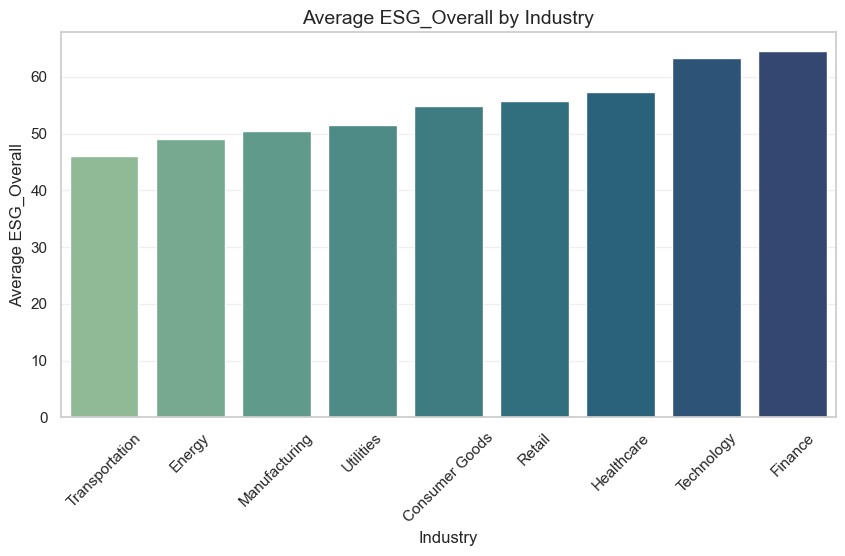

In [76]:
industry_esg = df.groupby("Industry")["ESG_Overall"].mean().sort_values()

plt.figure(figsize=(10,5))
sns.barplot(x=industry_esg.index, y=industry_esg.values, palette="crest")
plt.title("Average ESG_Overall by Industry", fontsize=14)
plt.ylabel("Average ESG_Overall")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()


In [77]:
print("\n📌 ESG averages by Region:")
display(region_esg.to_frame("ESG_Overall_mean"))

print("\n📌 ESG averages by Industry:")
display(industry_esg.to_frame("ESG_Overall_mean"))



📌 ESG averages by Region:


ESG_Overall_mean
Region                         
Middle East           43.444032
Africa                44.508612
Latin America         50.519841
Asia                  51.902333
North America         61.215065
Oceania               62.435160
Europe                67.865455


📌 ESG averages by Industry:


ESG_Overall_mean
Industry                        
Transportation         46.034499
Energy                 49.014815
Manufacturing          50.462626
Utilities              51.601274
Consumer Goods         54.829467
Retail                 55.681818
Healthcare             57.254395
Technology             63.345167
Finance                64.620434


#  Stage 1 — Raw Data Profiling & Exploratory Data Analysis (EDA)

This stage provides:
- Column summary
 - Statistical overview
 - Missing value analysis
 - Outlier visualization
 - Distribution plots
 - Industry/Region breakdowns

 These steps are crucial for verifying dataset quality before modeling.


In [3]:
# %% [markdown]
# ## 1.1 Dataset Structure and Summary
# Inspect columns, datatypes, and missing values.
# %%
print("=== Dataset Information ===")
df.info()

print("\n=== Summary Statistics (Numeric Columns) ===")
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")
display(df.describe())

print("\n=== Missing Values ===")
display(df.isnull().sum())
pd.reset_option('display.float_format')


=== Dataset Information ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CompanyID          11000 non-null  int64  
 1   CompanyName        11000 non-null  object 
 2   Industry           11000 non-null  object 
 3   Region             11000 non-null  object 
 4   Year               11000 non-null  int64  
 5   Revenue            11000 non-null  float64
 6   ProfitMargin       11000 non-null  float64
 7   MarketCap          11000 non-null  float64
 8   GrowthRate         10000 non-null  float64
 9   ESG_Overall        11000 non-null  float64
 10  ESG_Environmental  11000 non-null  float64
 11  ESG_Social         11000 non-null  float64
 12  ESG_Governance     11000 non-null  float64
 13  CarbonEmissions    11000 non-null  float64
 14  WaterUsage         11000 non-null  float64
 15  EnergyConsumption  11000 non-null  float64

CompanyID      Year    Revenue  ProfitMargin  MarketCap  GrowthRate  \
count  11,000.00 11,000.00  11,000.00     11,000.00  11,000.00   10,000.00   
mean      500.50  2,020.00   4,670.85         10.90  13,380.62        4.83   
std       288.69      3.16   9,969.95          8.76  39,922.87        9.42   
min         1.00  2,015.00      35.90        -20.00       1.80      -36.00   
25%       250.75  2,017.00     938.77          5.30   1,098.52       -1.32   
50%       500.50  2,020.00   1,902.30         10.50   3,096.45        4.90   
75%       750.25  2,023.00   4,342.62         16.30   9,995.50       11.00   
max     1,000.00  2,025.00 180,810.40         50.00 865,271.70       38.00   

       ESG_Overall  ESG_Environmental  ESG_Social  ESG_Governance  \
count    11,000.00          11,000.00   11,000.00       11,000.00   
mean         54.62              56.42       55.66           51.77   
std          15.89              26.77       23.36           25.32   
min           6.30               0.00        0.00            0.00   
25%          44.10              34.70       37.60           30.77   
50%          54.60              55.60       55.15           52.10   
75%          65.60              79.00       73.80           73.00   
max          98.80             100.00      100.00          100.00   

       CarbonEmissions    WaterUsage  EnergyConsumption  
count        11,000.00     11,000.00          11,000.00  
mean      1,271,462.35    560,044.15      11,658,393.75  
std       5,067,760.30  1,565,686.22      50,958,356.02  
min           2,042.20      1,021.10           5,105.50  
25%         122,852.95     64,884.67         306,916.12  
50%         292,073.45    203,880.45       1,221,745.45  
75%         740,731.12    525,187.97       5,616,436.73  
max     174,104,721.40 52,231,416.40   1,741,047,214.30


=== Missing Values ===


CompanyID               0
CompanyName             0
Industry                0
Region                  0
Year                    0
Revenue                 0
ProfitMargin            0
MarketCap               0
GrowthRate           1000
ESG_Overall             0
ESG_Environmental       0
ESG_Social              0
ESG_Governance          0
CarbonEmissions         0
WaterUsage              0
EnergyConsumption       0
dtype: int64

In [4]:
# %% [markdown]
# ## 1.2 Categorical Value Distribution  
# Check unique values in Industry and Region.
# %%
categorical_cols = ['Industry', 'Region']

for col in categorical_cols:
    print(f"\n=== Unique values for {col} ===")
    print(df[col].unique())
    print(f"\n=== Value counts for {col} ===")
    display(df[col].value_counts(dropna=False))




=== Unique values for Industry ===
['Retail' 'Transportation' 'Technology' 'Finance' 'Healthcare' 'Energy'
 'Consumer Goods' 'Utilities' 'Manufacturing']

=== Value counts for Industry ===


Healthcare        1331
Transportation    1287
Manufacturing     1287
Consumer Goods    1276
Finance           1243
Energy            1188
Utilities         1177
Retail            1166
Technology        1045
Name: Industry, dtype: int64


=== Unique values for Region ===
['Latin America' 'Asia' 'Africa' 'Middle East' 'Oceania' 'Europe'
 'North America']

=== Value counts for Region ===


Asia             1672
Oceania          1661
Middle East      1617
Europe           1540
North America    1540
Latin America    1507
Africa           1463
Name: Region, dtype: int64


Generating Box Plots for Outlier Analysis...


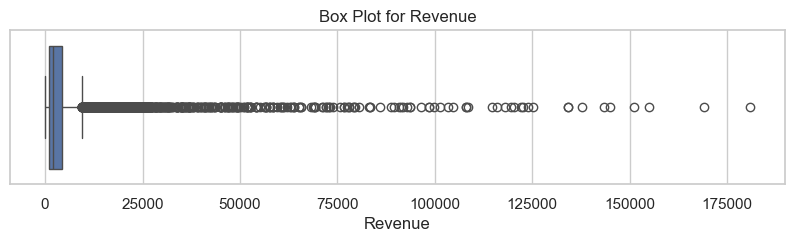

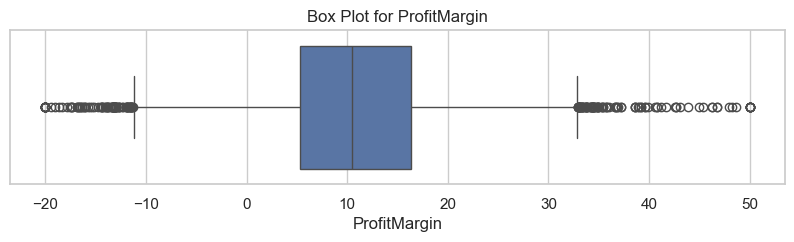

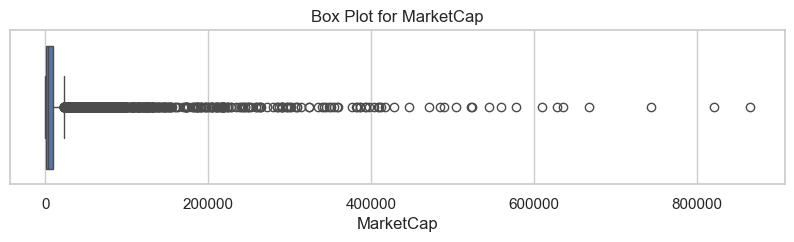

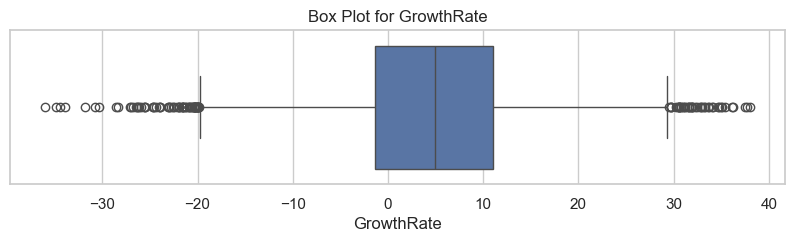

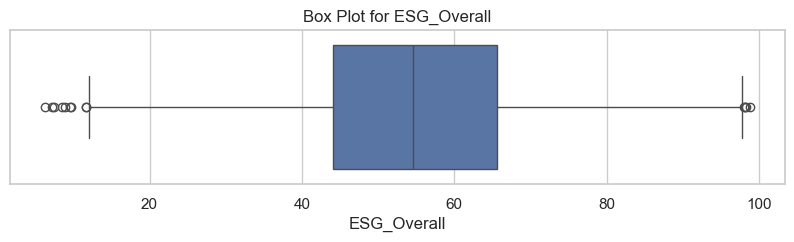

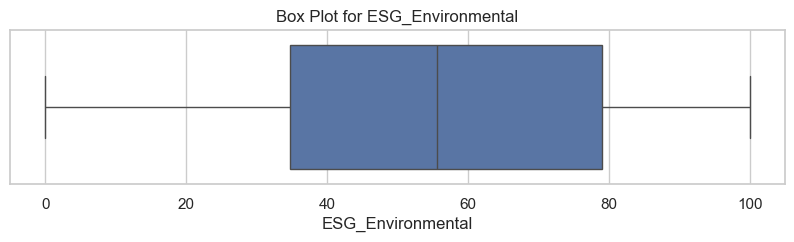

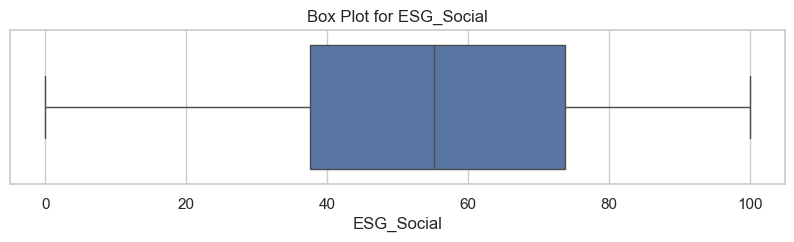

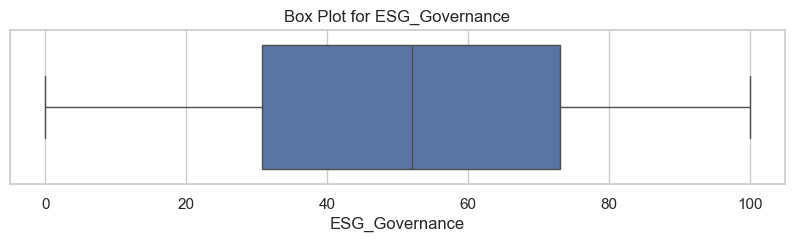

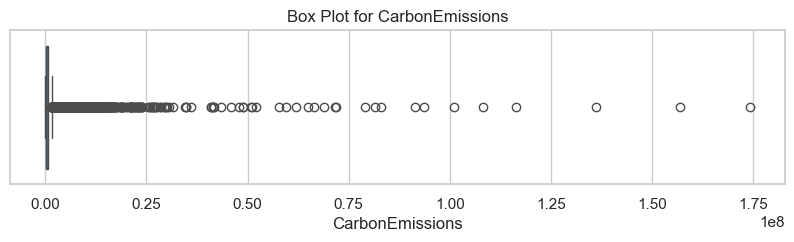

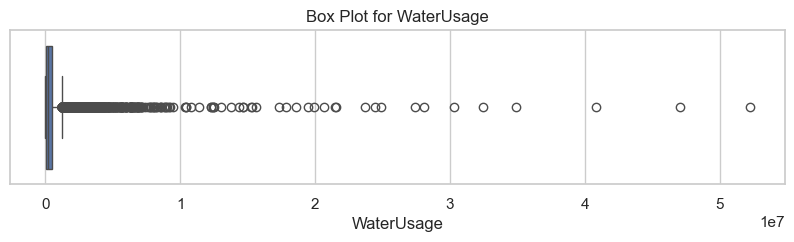

Box plot generation complete.


In [5]:
# %% [markdown]
# ## 1.3 Outlier Visualization  
# Using custom utilities (`visualize_outliers`).
# %%
numeric_features = [
    'Revenue', 'ProfitMargin', 'MarketCap', 'GrowthRate',
    'ESG_Overall', 'ESG_Environmental', 'ESG_Social', 'ESG_Governance',
    'CarbonEmissions', 'WaterUsage'
]

du.visualize_outliers(df, numeric_features)



Generating EDA Visualizations...

--- Correlation Heatmap ---
This shows how strongly numeric features are related to each other (1.0 = perfect positive, -1.0 = perfect negative).


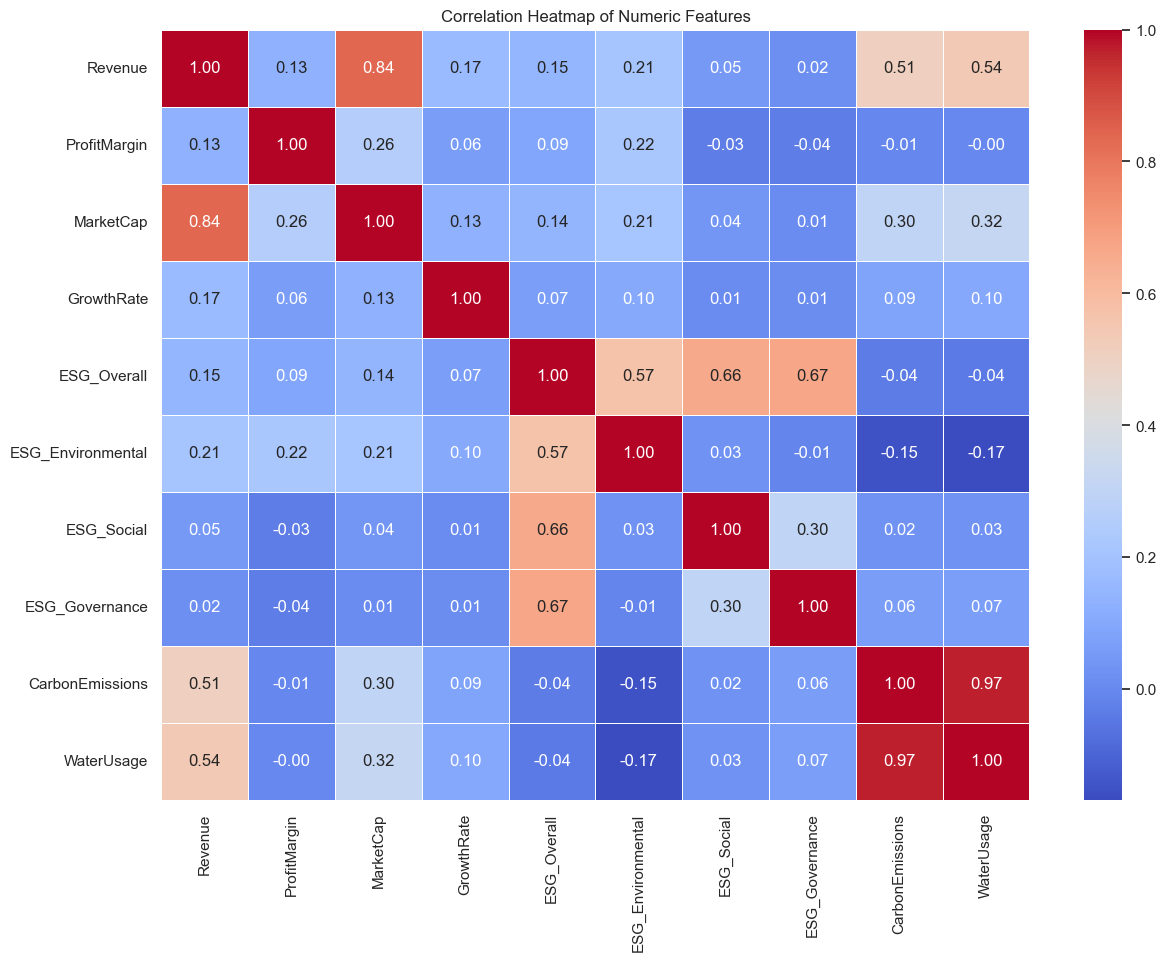


--- Histograms (Distributions) ---
These show the 'shape' of your numeric data.


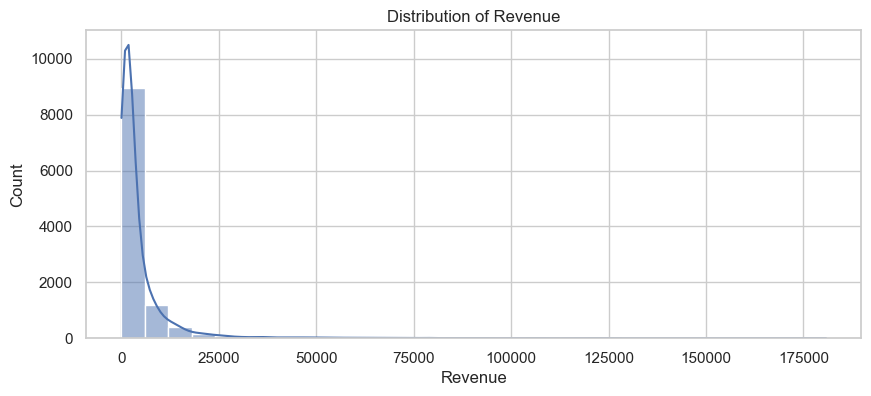

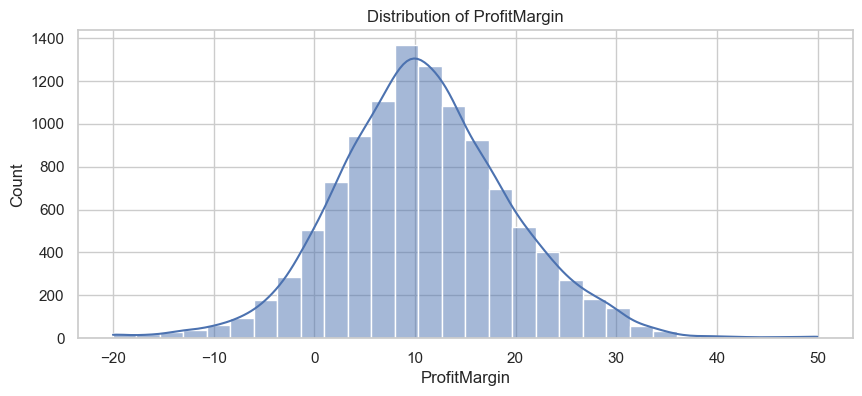

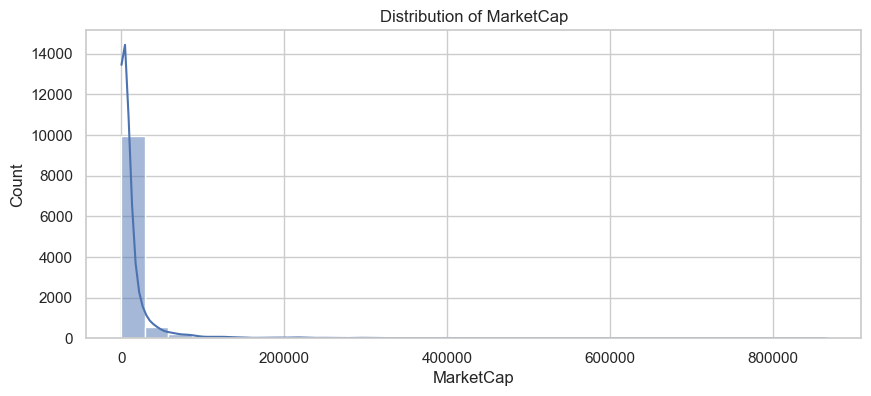

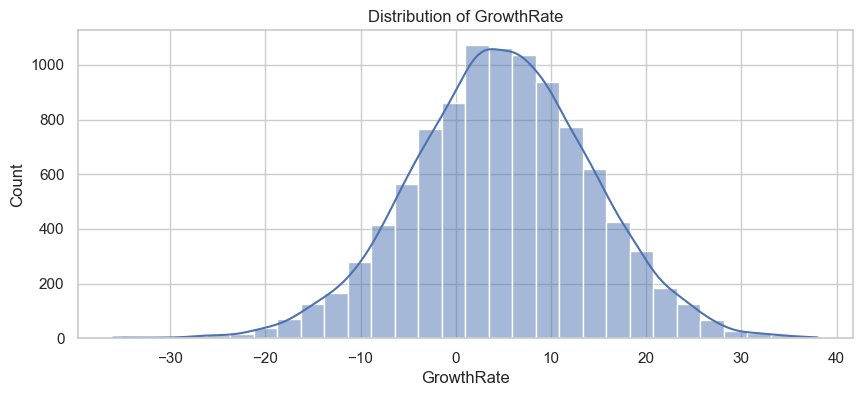

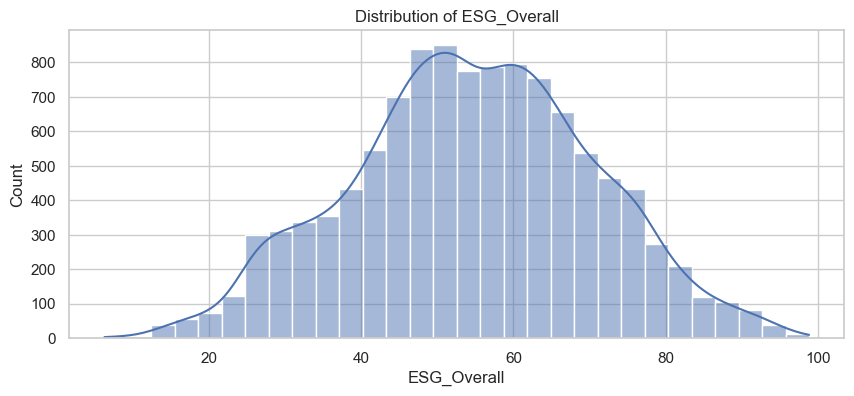

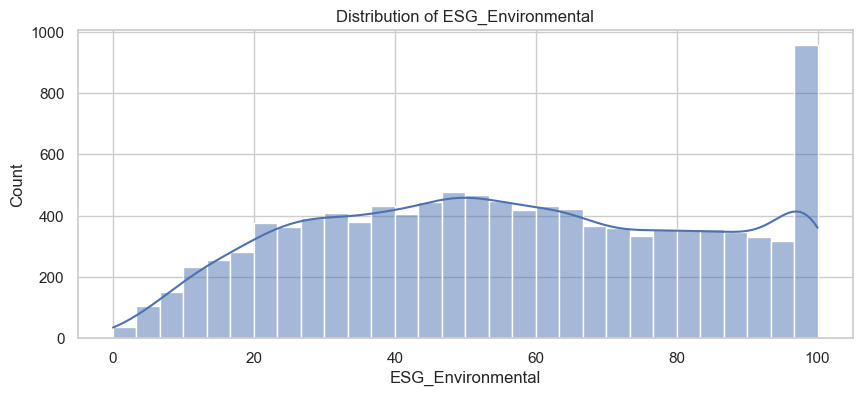

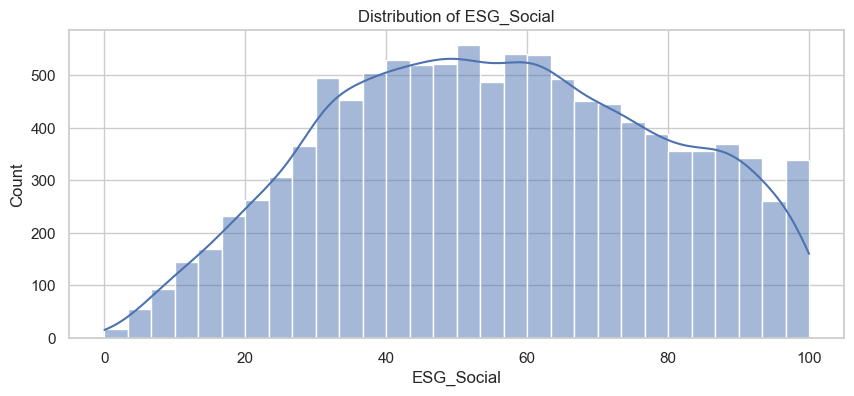

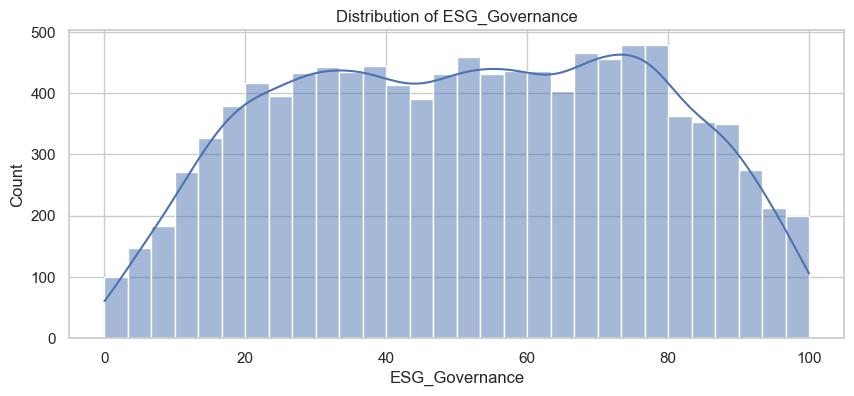

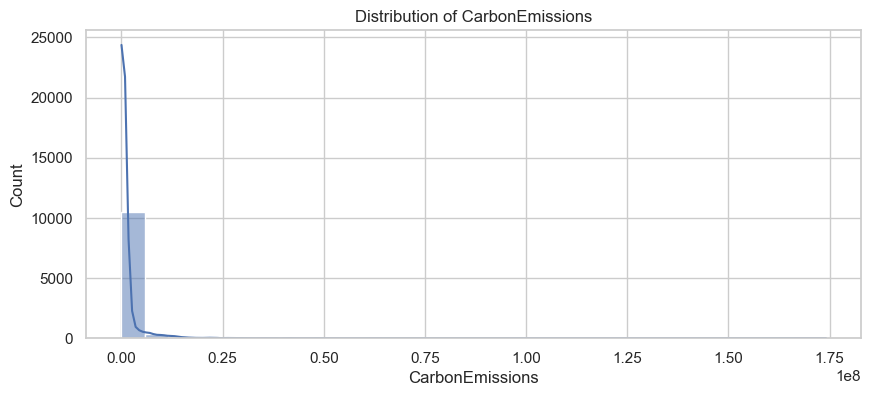

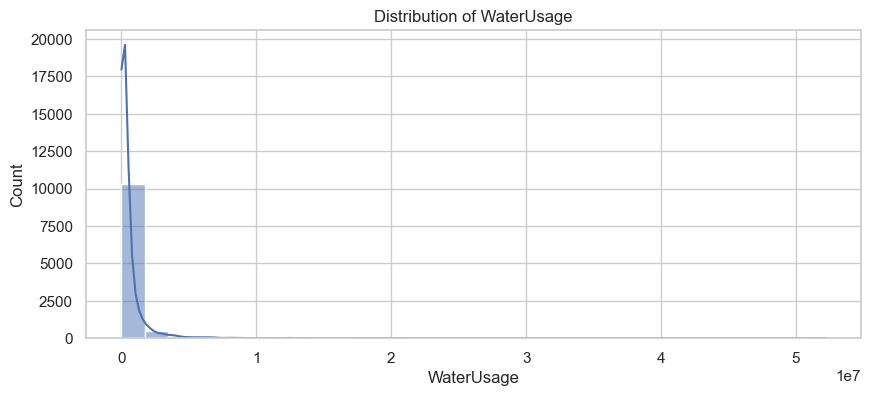


--- Count Plots (Categorical Data) ---
These show the counts for each category.


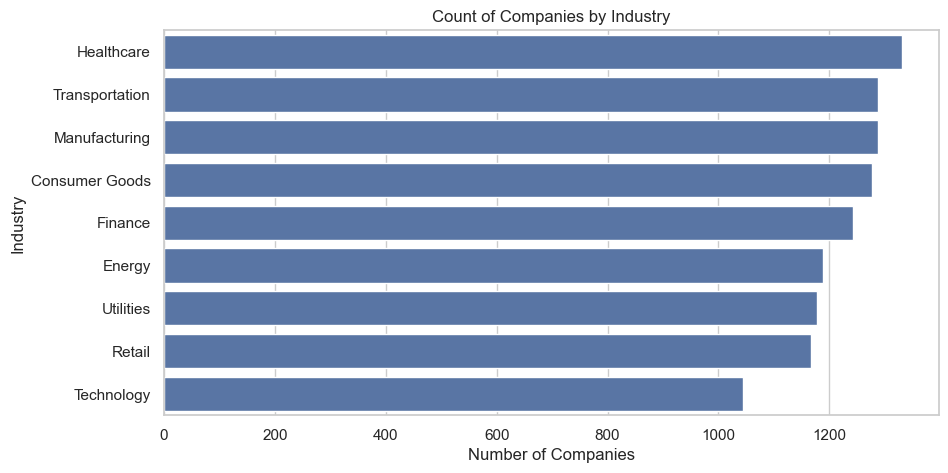

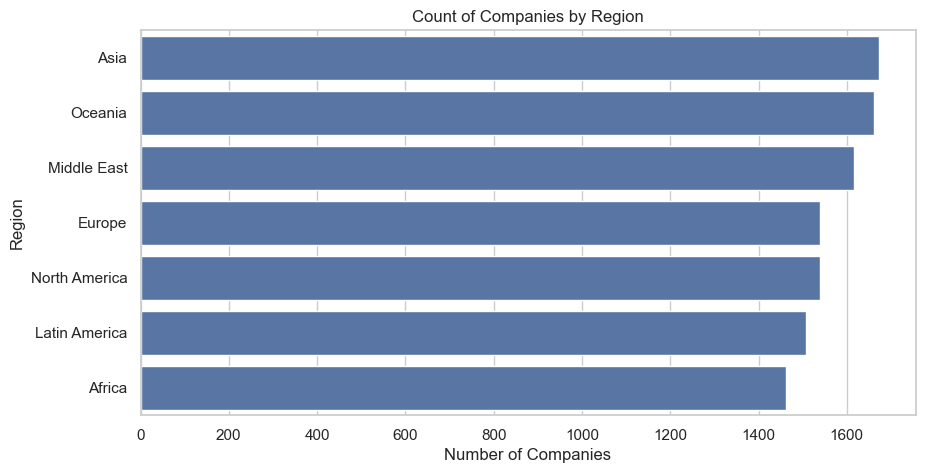

EDA visualization complete.


In [6]:
# %% [markdown]
# ## 1.4 Distribution Plots (Histogram + KDE)
# Explore shape and skewness.
# %%
# %%
du.perform_eda_visualizations(
    df,
    numeric_features,
    categorical_cols
)



# Stage 2 — Data Cleaning & Preprocessing

 In this stage we:
 - Apply log transformations to skewed features  
 - Apply one-hot encoding to Industry and Region  
 - Standard-scale numerical values  
 - Produce a clean `processed_df` used for baseline and MR pipelines

 The transformations are implemented inside:
 `feature_engineering_updated.py`


In [7]:
# %% [markdown]
# ## 2.1 Define Transformation Settings
# %%
# %%
cols_to_log_transform = ['Revenue', 'MarketCap', 'CarbonEmissions', 'WaterUsage']
cols_to_one_hot_encode = ['Industry', 'Region']

processed_df = fe.preprocess_data(
    df,
    cols_to_log_transform,
    cols_to_one_hot_encode
)
processed_df['GrowthRate'] = processed_df['GrowthRate'].fillna(processed_df['GrowthRate'].median())

print(processed_df.isnull().sum())
print("\n=== Processed Data Preview ===")
processed_df.head()





🚀 Starting preprocessing...
📌 Applying log1p to: ['Revenue', 'MarketCap', 'CarbonEmissions', 'WaterUsage']
📌 One-hot encoding: ['Industry', 'Region']
✅ Preprocessing completed.
CompanyID                  0
CompanyName                0
Year                       0
Revenue                    0
ProfitMargin               0
MarketCap                  0
GrowthRate                 0
ESG_Overall                0
ESG_Environmental          0
ESG_Social                 0
ESG_Governance             0
CarbonEmissions            0
WaterUsage                 0
EnergyConsumption          0
Industry_Energy            0
Industry_Finance           0
Industry_Healthcare        0
Industry_Manufacturing     0
Industry_Retail            0
Industry_Technology        0
Industry_Transportation    0
Industry_Utilities         0
Region_Asia                0
Region_Europe              0
Region_Latin America       0
Region_Middle East         0
Region_North America       0
Region_Oceania             0
dtype: int

CompanyID CompanyName  Year   Revenue  ProfitMargin  MarketCap  GrowthRate  \
0          1   Company_1  2015  6.131661           6.0   5.824524         4.9   
1          1   Company_1  2016  6.162894           4.6   5.906995         3.2   
2          1   Company_1  2017  6.338417           5.2   5.750666        19.2   
3          1   Company_1  2018  6.326865           4.3   5.648974        -1.1   
4          1   Company_1  2019  6.319869           4.9   6.289901        -0.7   

   ESG_Overall  ESG_Environmental  ESG_Social  ...  Industry_Retail  \
0         57.0               60.7        33.5  ...                1   
1         56.7               58.9        32.8  ...                1   
2         56.5               57.6        34.0  ...                1   
3         58.0               62.3        33.4  ...                1   
4         56.6               63.7        30.0  ...                1   

   Industry_Technology  Industry_Transportation  Industry_Utilities  \
0                    0                        0                   0   
1                    0                        0                   0   
2                    0                        0                   0   
3                    0                        0                   0   
4                    0                        0                   0   

   Region_Asia  Region_Europe  Region_Latin America  Region_Middle East  \
0            0              0                     1                   0   
1            0              0                     1                   0   
2            0              0                     1                   0   
3            0              0                     1                   0   
4            0              0                     1                   0   

   Region_North America  Region_Oceania  
0                     0               0  
1                     0               0  
2                     0               0  
3                     0               0  
4                     0               0  

[5 rows x 28 columns]

In [ ]:
# %%
print("=== Processed Data Info ===")
processed_df.info()


=== Processed Data Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CompanyID                11000 non-null  int64  
 1   CompanyName              11000 non-null  object 
 2   Year                     11000 non-null  int64  
 3   Revenue                  11000 non-null  float64
 4   ProfitMargin             11000 non-null  float64
 5   MarketCap                11000 non-null  float64
 6   GrowthRate               11000 non-null  float64
 7   ESG_Overall              11000 non-null  float64
 8   ESG_Environmental        11000 non-null  float64
 9   ESG_Social               11000 non-null  float64
 10  ESG_Governance           11000 non-null  float64
 11  CarbonEmissions          11000 non-null  float64
 12  WaterUsage               11000 non-null  float64
 13  EnergyConsumption        11000 non-null  float64

In [9]:
# %%
project_folder_path = r"D:\ESG research work\global conference"
processed_file_name = "processed_esg_financial_data_UPDATED.xlsx"

output_path = os.path.join(project_folder_path, processed_file_name)
du.save_data(processed_df, output_path)

print(f"Saved processed dataset to:\n{output_path}")


Successfully saved file to: D:\ESG research work\global conference\processed_esg_financial_data_UPDATED.xlsx
Saved processed dataset to:
D:\ESG research work\global conference\processed_esg_financial_data_UPDATED.xlsx


# Stage 3 — Baseline Modeling (Before Machine Reasoning Layer)

 In this stage, we build the baseline ESG prediction models using only:
 - Financial metrics
 - One-hot encoded Industry & Region
 - Standard preprocessing

 These models serve as the "control" before adding Machine Reasoning features.


In [10]:
# %%
import model_utils as mu

target_column = "ESG_Overall"

# Leakage columns to drop BEFORE modeling
columns_to_drop = [
    'CompanyID', 'CompanyName',
    'ESG_Environmental', 'ESG_Social', 'ESG_Governance',
    'CarbonEmissions', 'WaterUsage', 'EnergyConsumption'
]

print("\nPreparing baseline modeling data...")
X_train, X_test, y_train, y_test, feature_names = mu.prepare_data_for_modeling(
    processed_df,
    target_column,
    columns_to_drop
)



Preparing baseline modeling data...

Preparing data for modeling...
  - Target (y): ESG_Overall
  - Features (X): ['Year', 'Revenue', 'ProfitMargin', 'MarketCap', 'GrowthRate', 'Industry_Energy', 'Industry_Finance', 'Industry_Healthcare', 'Industry_Manufacturing', 'Industry_Retail', 'Industry_Technology', 'Industry_Transportation', 'Industry_Utilities', 'Region_Asia', 'Region_Europe', 'Region_Latin America', 'Region_Middle East', 'Region_North America', 'Region_Oceania']
  - Scaling data using StandardScaler...
  - Training set size: 8800 samples
  - Testing set size:  2200 samples


In [11]:
# %% 
# Fix missing values for baseline models
missing_cols = processed_df.columns[processed_df.isnull().any()]

print("Columns with missing values:", missing_cols.tolist())

processed_df = fe.impute_missing_values(processed_df, missing_cols)

# Re-prepare modeling data after fixing missing values
X_train, X_test, y_train, y_test, feature_names = mu.prepare_data_for_modeling(
    processed_df,
    target_column,
    columns_to_drop
)

print("Missing values fixed. Rebuilding baseline models...")


Columns with missing values: []

📌 Imputing missing values...

Preparing data for modeling...
  - Target (y): ESG_Overall
  - Features (X): ['Year', 'Revenue', 'ProfitMargin', 'MarketCap', 'GrowthRate', 'Industry_Energy', 'Industry_Finance', 'Industry_Healthcare', 'Industry_Manufacturing', 'Industry_Retail', 'Industry_Technology', 'Industry_Transportation', 'Industry_Utilities', 'Region_Asia', 'Region_Europe', 'Region_Latin America', 'Region_Middle East', 'Region_North America', 'Region_Oceania']
  - Scaling data using StandardScaler...
  - Training set size: 8800 samples
  - Testing set size:  2200 samples
Missing values fixed. Rebuilding baseline models...



Training Linear Regression model...
  - Model training complete.

Evaluating model performance...
  - R-squared (R²):   0.4232
  - Root Mean Squared Error (RMSE): 11.6686
  - Generating Actual vs. Predicted plot...


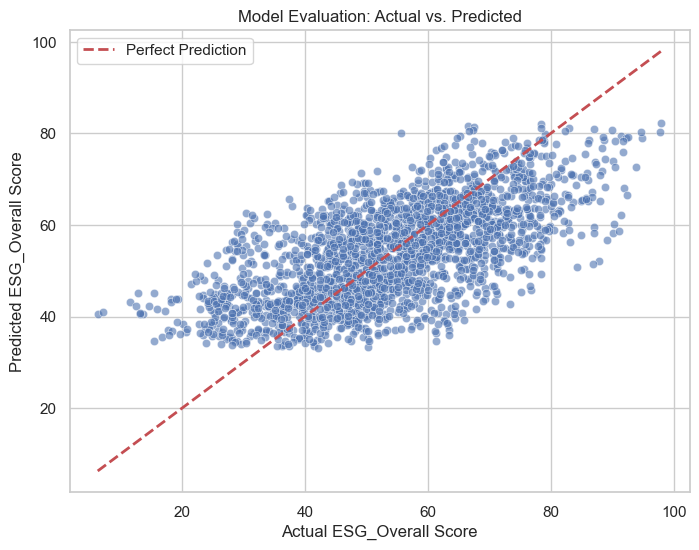

In [12]:
# %% [markdown]
# ## 3.2 Linear Regression (Baseline Model)
# %%
lr_model = mu.train_linear_regression(X_train, y_train)
mu.evaluate_model(lr_model, X_test, y_test)



Training Random Forest Regressor model...
  - Model training complete.

Evaluating model performance...
  - R-squared (R²):   0.6287
  - Root Mean Squared Error (RMSE): 9.3616
  - Generating Actual vs. Predicted plot...


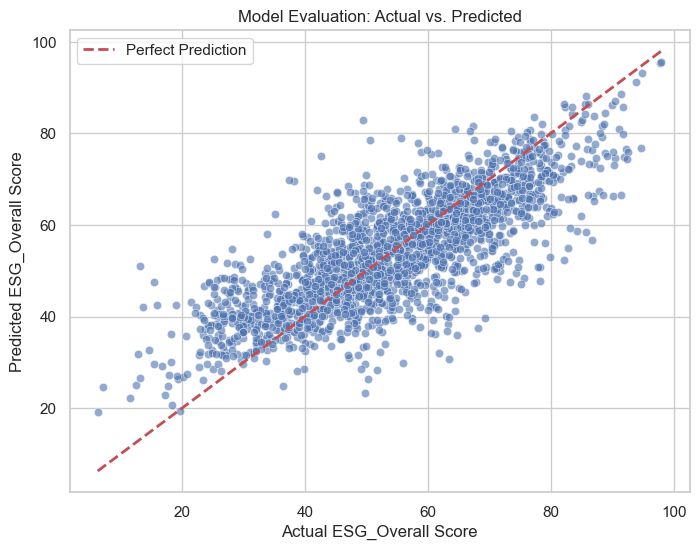

In [13]:
# %% [markdown]
# ## 3.3 Random Forest (Baseline Model)
# %%
rf_base = mu.train_random_forest(X_train, y_train)
mu.evaluate_model(rf_base, X_test, y_test)



Training XGBoost Regressor model...
  - Model training complete.

Evaluating model performance...
  - R-squared (R²):   0.5554
  - Root Mean Squared Error (RMSE): 10.2447
  - Generating Actual vs. Predicted plot...


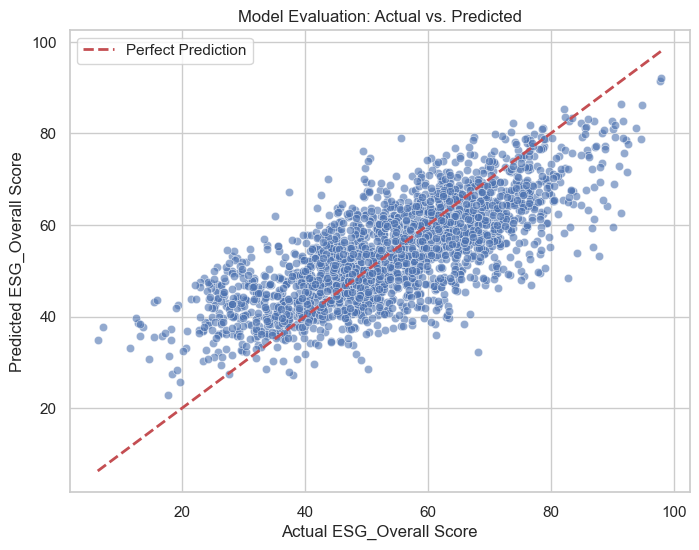

In [14]:
# %% [markdown]
# ## 3.4 XGBoost Model
# %%
xgb_base = mu.train_xgboost_model(X_train, y_train)
mu.evaluate_model(xgb_base, X_test, y_test)



Training Tuned Deep Learning (MLP) model...
  - Model training complete.

Evaluating model performance...
  - R-squared (R²):   0.6171
  - Root Mean Squared Error (RMSE): 9.5064
  - Generating Actual vs. Predicted plot...


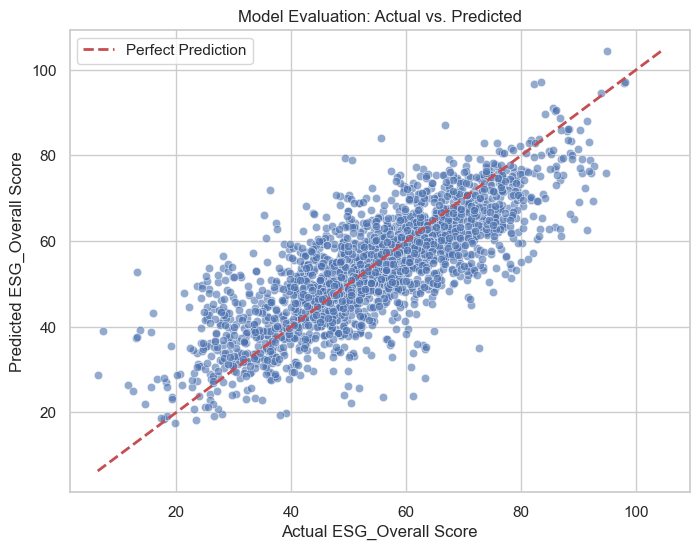

In [15]:
# %% [markdown]
# ## 3.5 Deep Learning (MLP Regressor)
# %%
dl_model = mu.train_deep_learning_model(X_train, y_train)
mu.evaluate_model(dl_model, X_test, y_test)


In [13]:
# %% [markdown]
# ## 3.6 Hyperparameter Tuning — Random Forest
# Grid search over depth, estimators, min leaf size, max_features
# %%
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = {
    "n_estimators": [400, 600, 800],
    "max_depth": [None, 16, 20, 24],
    "min_samples_leaf": [1, 2, 3],
    "max_features": ['sqrt', 0.8, 1.0],
}

best = None
candidates = []

for ne in grid["n_estimators"]:
    for md in grid["max_depth"]:
        for ml in grid["min_samples_leaf"]:
            for mf in grid["max_features"]:

                model = RandomForestRegressor(
                    n_estimators=ne,
                    max_depth=md,
                    min_samples_leaf=ml,
                    max_features=mf,
                    random_state=42,
                    n_jobs=-1
                )

                scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="r2")
                candidates.append((scores.mean(), scores.std(), ne, md, ml, mf))

best = max(candidates, key=lambda x: x[0])
print("\nBest RF model:", best)



Best RF model: (0.6237349408418184, 0.003717802121672422, 800, 24, 1, 0.8)


In [14]:
# %%
best_mean, best_std, ne, md, ml, mf = best

rf_tuned = RandomForestRegressor(
    n_estimators=500,
    max_depth=12,
    min_samples_leaf=4,
    min_samples_split=4,
    max_features='sqrt',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)



rf_tuned.fit(X_train, y_train)

print(f"Train R²: {r2_score(y_train, rf_tuned.predict(X_train)):.3f}")
print(f"Test  R²: {r2_score(y_test,  rf_tuned.predict(X_test)):.3f}")


Train R²: 0.635
Test  R²: 0.524


In [15]:
# %%
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

def evaluate_train_test(model, X_train, y_train, X_test, y_test, name="Model"):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    r2_tr = r2_score(y_train, y_pred_train)
    r2_te = r2_score(y_test, y_pred_test)
    rmse_te = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    print(f"\n=== {name} ===")
    print(f"Train R²: {r2_tr:.3f}")
    print(f"Test  R²: {r2_te:.3f}")
    print(f"Test RMSE: {rmse_te:.3f}")
    
    return [name, r2_tr, r2_te, rmse_te]


In [19]:
# %%
results = []

results.append(evaluate_train_test(lr_model, X_train, y_train, X_test, y_test, "Linear Regression"))
#results.append(evaluate_train_test(rf_base, X_train, y_train, X_test, y_test, "Random Forest (Base)"))
results.append(evaluate_train_test(rf_tuned, X_train, y_train, X_test, y_test, "Random Forest (Tuned)"))
results.append(evaluate_train_test(xgb_base, X_train, y_train, X_test, y_test, "XGBoost"))
results.append(evaluate_train_test(dl_model, X_train, y_train, X_test, y_test, "Deep Learning (MLP)"))
# %%
import pandas as pd

results_df = pd.DataFrame(
    results,
    columns=["Model", "Train_R2", "Test_R2", "RMSE"]
)

print("\n\n=== 📊 Full Model Comparison (Train vs Test) ===")
display(results_df)




=== Linear Regression ===
Train R²: 0.456
Test  R²: 0.423
Test RMSE: 11.669

=== Random Forest (Tuned) ===
Train R²: 0.635
Test  R²: 0.524
Test RMSE: 10.601

=== XGBoost ===
Train R²: 0.702
Test  R²: 0.555
Test RMSE: 10.245

=== Deep Learning (MLP) ===
Train R²: 0.748
Test  R²: 0.617
Test RMSE: 9.506


=== 📊 Full Model Comparison (Train vs Test) ===


Model  Train_R2   Test_R2       RMSE
0      Linear Regression  0.456045  0.423153  11.668634
1  Random Forest (Tuned)  0.634773  0.523875  10.601082
2                XGBoost  0.701976  0.555352  10.244668
3    Deep Learning (MLP)  0.748282  0.617129   9.506391

Preparing baseline RF data for SHAP...
Retraining Tuned Random Forest baseline model for SHAP...
Creating SHAP explainer...
Computing SHAP values...
Plotting summary SHAP plot...


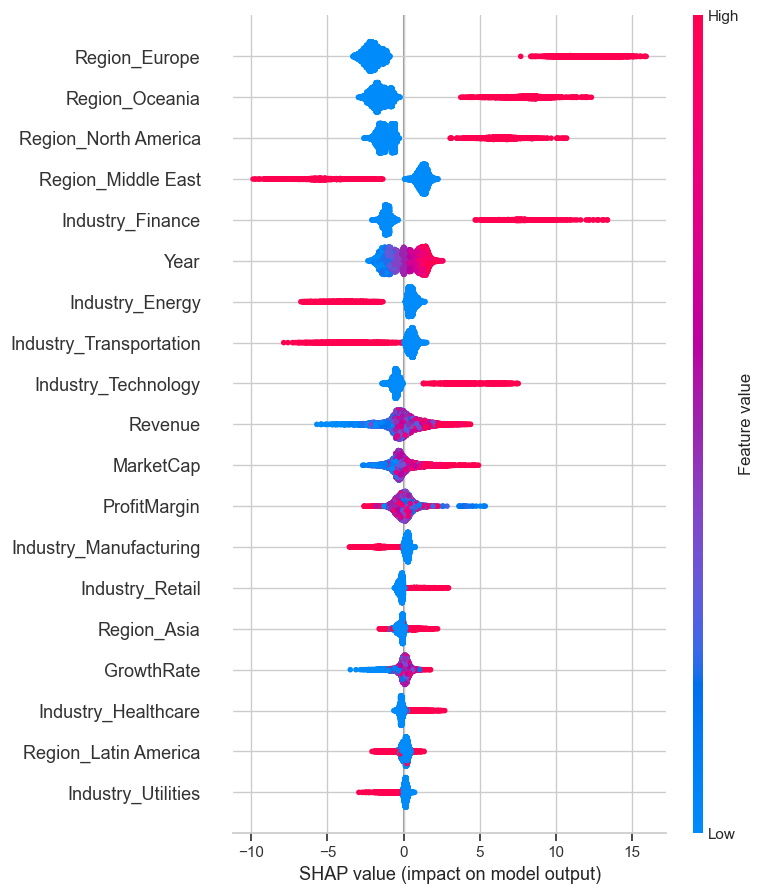

Plotting SHAP bar plot...


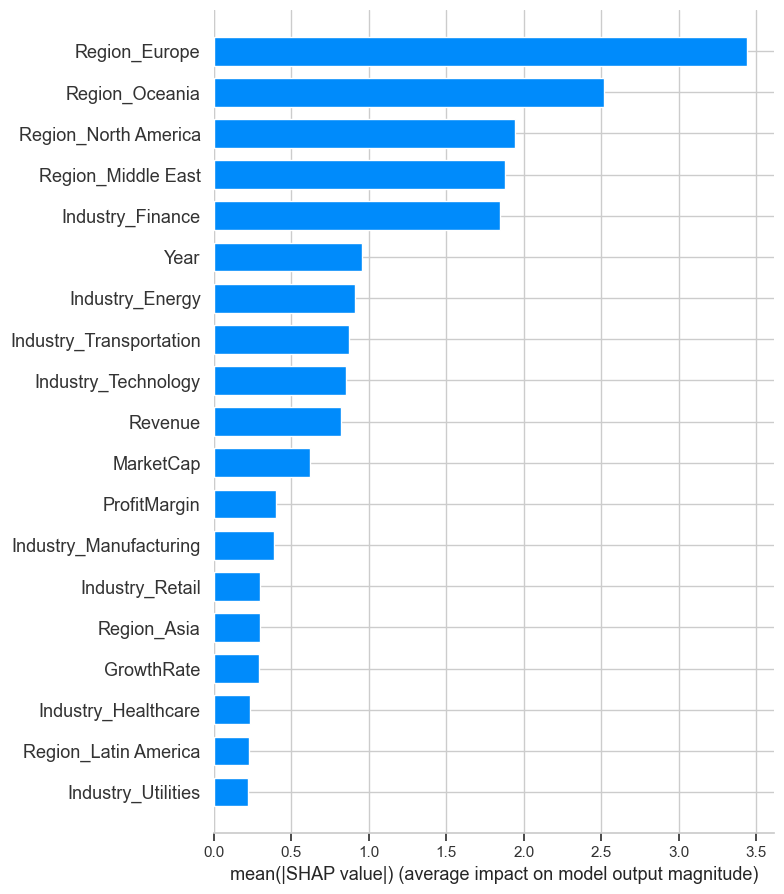

SHAP analysis completed for tuned RF baseline model!


In [20]:
# ======================================================
# SHAP for BASELINE TUNED RANDOM FOREST MODEL (FIXED)
# ======================================================

import shap
import numpy as np
import pandas as pd

print("Preparing baseline RF data for SHAP...")

# Use the SAME baseline features used for tuned RF
X_train_base_df = pd.DataFrame(X_train, columns=feature_names)

# Convert to float32 for stability (SHAP prefers float32)
X_train_base_np = X_train_base_df.astype(np.float32).values
y_train_base_np = y_train.values.astype(np.float32)

# ------------------------------------------------------
# Retrain RF model (ensures clean model for SHAP)
# ------------------------------------------------------
print("Retraining Tuned Random Forest baseline model for SHAP...")
rf_base_shap = RandomForestRegressor(
    n_estimators=500,
    max_depth=12,
    min_samples_leaf=4,
    min_samples_split=4,
    max_features='sqrt',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)


rf_base_shap.fit(X_train_base_np, y_train_base_np)

# ------------------------------------------------------
# Create SHAP explainer
# ------------------------------------------------------
print("Creating SHAP explainer...")
explainer_base = shap.TreeExplainer(rf_base_shap)

# ------------------------------------------------------
# Compute SHAP values
# ------------------------------------------------------
print("Computing SHAP values...")
shap_values_base = explainer_base.shap_values(X_train_base_np)

# ------------------------------------------------------
# SHAP SUMMARY PLOT
# ------------------------------------------------------
print("Plotting summary SHAP plot...")
shap.summary_plot(
    shap_values_base,
    X_train_base_df,
    feature_names=X_train_base_df.columns,
    max_display=20
)

# ------------------------------------------------------
# SHAP BAR PLOT (GLOBAL IMPORTANCE)
# ------------------------------------------------------
print("Plotting SHAP bar plot...")
shap.summary_plot(
    shap_values_base,
    X_train_base_df,
    feature_names=X_train_base_df.columns,
    plot_type="bar",
    max_display=20
)

print("SHAP analysis completed for tuned RF baseline model!")


Preparing baseline data for SHAP...
Retraining XGBoost baseline model for SHAP...
Creating SHAP explainer...
Computing SHAP values...
Plotting base model SHAP summary...


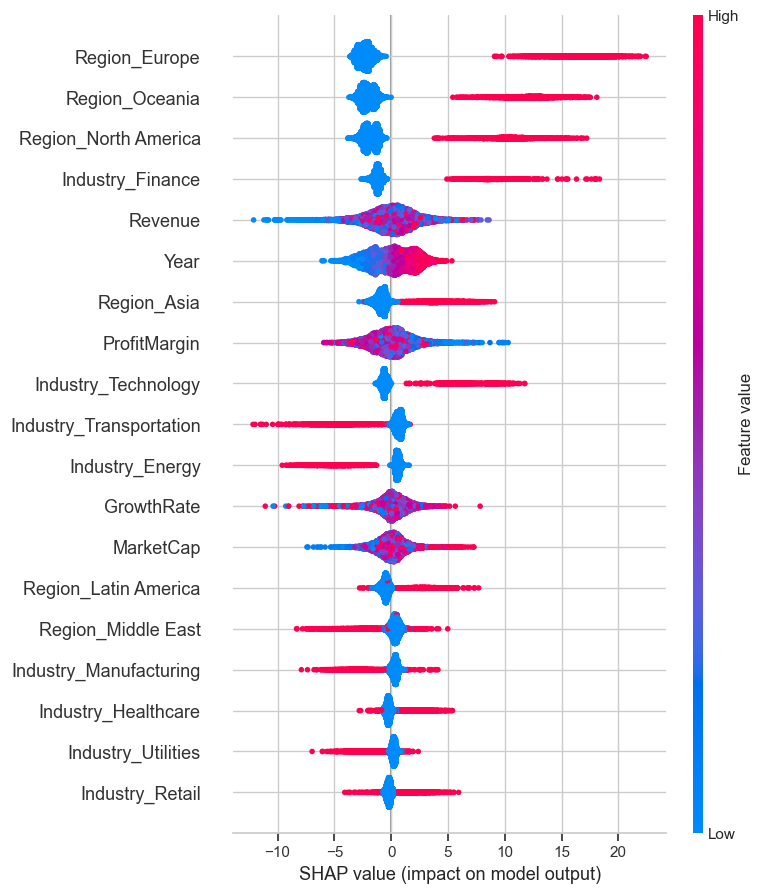

In [ ]:
# ======================================================
# SHAP for BASELINE XGBOOST MODEL (FIXED)
# ======================================================

import shap
import numpy as np
import pandas as pd
import xgboost as xgb        # <-- REQUIRED IMPORT

print("Preparing baseline data for SHAP...")

# Use the SAME baseline features used for baseline XGB
X_train_base_df = pd.DataFrame(X_train, columns=feature_names)

# Convert to float32 for SHAP stability
X_train_base_np = X_train_base_df.astype(np.float32).values
y_train_base_np = y_train.values.astype(np.float32)

print("Retraining XGBoost baseline model for SHAP...")
xgb_base_shap = xgb.XGBRegressor(
    n_estimators=600,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

xgb_base_shap.fit(X_train_base_np, y_train_base_np)

print("Creating SHAP explainer...")
explainer_base = shap.TreeExplainer(xgb_base_shap)

print("Computing SHAP values...")
shap_values_base = explainer_base.shap_values(X_train_base_np)

print("Plotting base model SHAP summary...")
shap.summary_plot(
    shap_values_base,
    X_train_base_df,
    feature_names=X_train_base_df.columns,
    max_display=20
)


Preparing baseline data for SHAP...
Retraining XGBoost baseline model for SHAP...
Creating SHAP explainer...
Computing SHAP values...
Plotting base model SHAP summary...


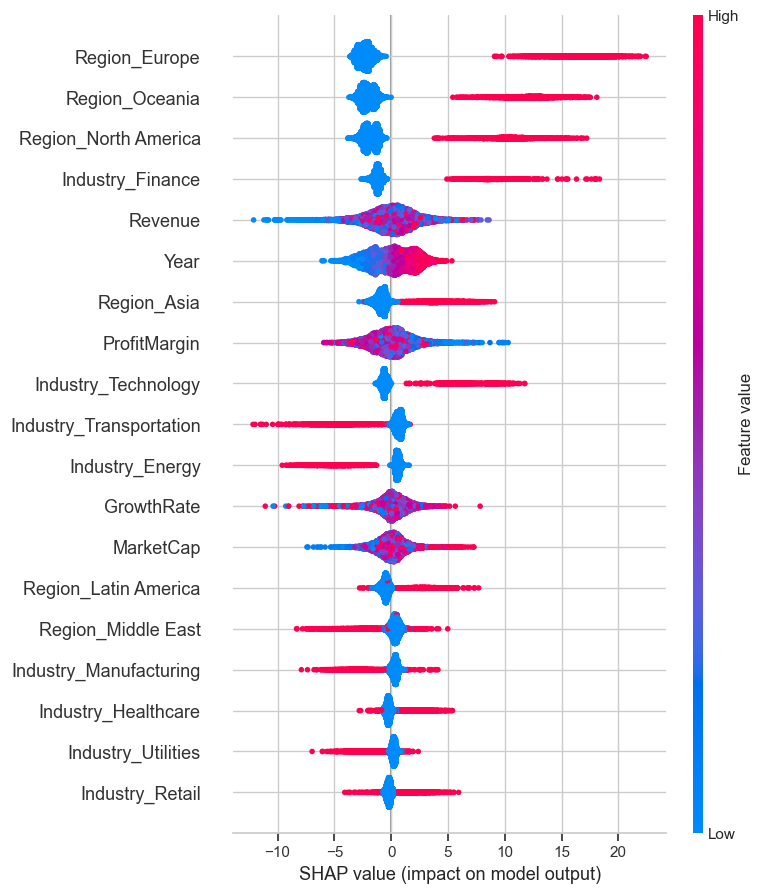

In [18]:
# ======================================================
# SHAP for BASELINE XGBOOST MODEL (FIXED)
# ======================================================

import shap
import numpy as np
import pandas as pd
import xgboost as xgb        # <-- REQUIRED IMPORT

print("Preparing baseline data for SHAP...")

# Use the SAME baseline features used for baseline XGB
X_train_base_df = pd.DataFrame(X_train, columns=feature_names)

# Convert to float32 for SHAP stability
X_train_base_np = X_train_base_df.astype(np.float32).values
y_train_base_np = y_train.values.astype(np.float32)

print("Retraining XGBoost baseline model for SHAP...")
xgb_base_shap = xgb.XGBRegressor(
    n_estimators=600,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

xgb_base_shap.fit(X_train_base_np, y_train_base_np)

print("Creating SHAP explainer...")
explainer_base = shap.TreeExplainer(xgb_base_shap)

print("Computing SHAP values...")
shap_values_base = explainer_base.shap_values(X_train_base_np)

print("Plotting base model SHAP summary...")
shap.summary_plot(
    shap_values_base,
    X_train_base_df,
    feature_names=X_train_base_df.columns,
    max_display=20
)


## Rechecking the data

In [21]:
print("\nMissing values in PROCESSED DF:")
print(processed_df.isnull().sum())



Missing values in PROCESSED DF:
CompanyID                  0
CompanyName                0
Year                       0
Revenue                    0
ProfitMargin               0
MarketCap                  0
GrowthRate                 0
ESG_Overall                0
ESG_Environmental          0
ESG_Social                 0
ESG_Governance             0
CarbonEmissions            0
WaterUsage                 0
EnergyConsumption          0
Industry_Energy            0
Industry_Finance           0
Industry_Healthcare        0
Industry_Manufacturing     0
Industry_Retail            0
Industry_Technology        0
Industry_Transportation    0
Industry_Utilities         0
Region_Asia                0
Region_Europe              0
Region_Latin America       0
Region_Middle East         0
Region_North America       0
Region_Oceania             0
dtype: int64


In [22]:
df_nulls = processed_df.isnull().sum()
df_nulls[df_nulls > 0]


Series([], dtype: int64)

# Stage 4 — Machine Reasoning Layer



## 4.1 Rule besed (median rule)

In [29]:
import mr_utils_updated as mru

violators_df, compliance_score = mru.check_esg_rules(df)

print("Compliance score added. Sample:")
display(compliance_score.head())
print(compliance_score.value_counts())





--- Checking Multi-Region ESG Rule ---
Using median ProfitMargin=10.50, ESG=54.60
Found 2587 potential red-flag companies.
Compliance score added. Sample:


0    0
1    0
2    0
3    0
4    0
Name: compliance_violation_score, dtype: int32

0    8413
1    2108
2     391
3      88
Name: compliance_violation_score, dtype: int64


In [30]:
print("\n🔎 Computing SEVERITY for MEDIAN rule...")

df_med = df.copy()
df_med["compliance_violation_score"] = compliance_score  # attach rule score

# 1. Expected ESG per Industry × Region (median benchmark)
expected_esg = (
    df_med.groupby(["Industry", "Region"])["ESG_Overall"]
    .median()
    .reset_index()
    .rename(columns={"ESG_Overall": "ESG_expected_median"})
)

# 2. Merge benchmark
df_med = df_med.merge(expected_esg, on=["Industry", "Region"], how="left")

# 3. Severity gap
df_med["severity_gap"] = df_med["ESG_expected_median"] - df_med["ESG_Overall"]

# 4. Weighted severity
df_med["severity_weighted"] = (
    df_med["severity_gap"] * df_med["compliance_violation_score"]
)




🔎 Computing SEVERITY for MEDIAN rule...


In [ ]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

print("\n📘 FULL Median-Rule Severity Dataset:")
display(
    df_med[
        [
            "Industry", "Region", "ESG_Overall", "ESG_expected_median",
            "severity_gap", "compliance_violation_score", "severity_weighted"
        ]
    ]
)

pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")


In [32]:
print("\n🚨 RED-FLAG companies based on MEDIAN RULE:")
display(df_med[df_med["compliance_violation_score"] > 0].sort_values(
    "severity_weighted", ascending=False
))



🚨 RED-FLAG companies based on MEDIAN RULE:


CompanyID  CompanyName        Industry       Region  Year  Revenue  \
968           89   Company_89       Utilities       Europe  2015   1212.2   
969           89   Company_89       Utilities       Europe  2016   1378.9   
971           89   Company_89       Utilities       Europe  2018   1209.5   
970           89   Company_89       Utilities       Europe  2017   1310.7   
972           89   Company_89       Utilities       Europe  2019   1355.0   
...          ...          ...             ...          ...   ...      ...   
10767        979  Company_979          Energy  Middle East  2024  19656.6   
3077         280  Company_280  Transportation       Africa  2023    511.0   
9666         879  Company_879       Utilities       Africa  2023   1204.6   
10897        991  Company_991  Transportation  Middle East  2022    817.7   
9664         879  Company_879       Utilities       Africa  2021   1340.0   

       ProfitMargin  MarketCap  GrowthRate  ESG_Overall  ESG_Environmental  \
968            14.3     1500.4         NaN         29.3               28.3   
969            14.0     1654.7        13.8         29.4               30.6   
971            15.3     2000.8        -7.7         30.5               31.6   
970            15.1     2507.8        -5.0         31.4               32.7   
972            12.9     2104.8        12.0         31.8               33.8   
...             ...        ...         ...          ...                ...   
10767          11.6    21731.6         3.1         51.0               53.4   
3077           32.6     2119.5       -15.7         53.4               97.6   
9666           11.1     1978.9        -5.9         53.4               87.3   
10897          11.5     1755.4         5.1         49.3               47.5   
9664           10.8     1314.2         3.9         53.5               90.1   

       ESG_Social  ESG_Governance  CarbonEmissions  WaterUsage  \
968          44.8            14.8         971444.2    607152.6   
969          46.4            11.3        1087233.0    679520.6   
971          49.3            10.7         947226.4    592016.5   
970          50.4            11.2        1018579.1    636611.9   
972          50.6            10.9        1044245.0    652653.1   
...           ...             ...              ...         ...   
10767        51.9            47.8       16247073.0   4874121.9   
3077         42.9            19.7         158467.2     26411.2   
9666         37.8            35.0         567325.3    354578.3   
10897        40.3            60.0         425786.6     70964.4   
9664         38.5            31.7         610296.2    381435.1   

       EnergyConsumption  compliance_violation_score  ESG_expected_median  \
968            9714442.1                           3                 61.1   
969           10872329.7                           3                 61.1   
971            9472264.2                           3                 61.1   
970           10185790.8                           3                 61.1   
972           10442450.2                           3                 61.1   
...                  ...                         ...                  ...   
10767        162470730.5                           1                 35.3   
3077            528224.0                           1                 37.4   
9666           5673253.2                           1                 37.2   
10897          1419288.7                           1                 33.0   
9664           6102961.9                           1                 37.2   

       severity_gap  severity_weighted  
968            31.8               95.4  
969            31.7               95.1  
971            30.6               91.8  
970            29.7               89.1  
972            29.3               87.9  
...             ...                ...  
10767         -15.7              -15.7  
3077          -16.0              -16.0  
9666          -16.2              -16.2  
10897         -16

In [33]:
df_med[df_med["compliance_violation_score"] > 0].to_csv("median_rule_violators.csv", index=False)
print("Saved as median_rule_violators.csv")


Saved as median_rule_violators.csv


## 4.2 Dynamic Quantile-Based Compliance Score

In [35]:
# 4.2 Dynamic Quantile-Based Compliance Score

df_dynamic = fe.add_dynamic_compliance_and_profit_size(
    df_original=df,
    ohe_df=processed_df
)

print("Dynamic rule features added:")
df_dynamic[["compliance_violation_score", "profit_per_size"]].head()


✅ Dynamic compliance + profit_per_size added.
Dynamic rule features added:


compliance_violation_score  profit_per_size
0                           0         1.360593
1                           0         1.292417
2                           0         1.802489
3                           0         1.973145
4                           0         1.030478

In [36]:
print("\n⚡ Computing SEVERITY for DYNAMIC rule...")

# df_dynamic already created from your earlier step:
# df_dynamic = fe.add_dynamic_compliance_and_profit_size(df_original=df, ohe_df=processed_df)

df_dyn = df_dynamic.copy()

# 1. Compute expected ESG median for each Industry × Region
dyn_expected_esg = (
    df_dyn.groupby(["Industry", "Region"])["ESG_Overall"]
    .median()
    .reset_index()
    .rename(columns={"ESG_Overall": "ESG_expected_dynamic"})
)

# 2. Merge into dataset
df_dyn = df_dyn.merge(dyn_expected_esg, on=["Industry", "Region"], how="left")

# 3. Compute residual ESG gap
df_dyn["severity_gap_dynamic"] = df_dyn["ESG_expected_dynamic"] - df_dyn["ESG_Overall"]

# 4. Weighted severity (gap × dynamic rule score)
df_dyn["severity_weighted_dynamic"] = (
    df_dyn["severity_gap_dynamic"] * df_dyn["compliance_violation_score"]
)

print("Dynamic severity calculation complete!")
display(df_dyn.head())



⚡ Computing SEVERITY for DYNAMIC rule...
Dynamic severity calculation complete!


CompanyID CompanyName  Year  Revenue  ProfitMargin  MarketCap  GrowthRate  \
0          1   Company_1  2015    459.2           6.0      337.5         4.9   
1          1   Company_1  2016    473.8           4.6      366.6         3.2   
2          1   Company_1  2017    564.9           5.2      313.4        19.2   
3          1   Company_1  2018    558.4           4.3      283.0        -1.1   
4          1   Company_1  2019    554.5           4.9      538.1        -0.7   

   ESG_Overall  ESG_Environmental  ESG_Social  ...  Region_Middle East  \
0         57.0               60.7        33.5  ...                   0   
1         56.7               58.9        32.8  ...                   0   
2         56.5               57.6        34.0  ...                   0   
3         58.0               62.3        33.4  ...                   0   
4         56.6               63.7        30.0  ...                   0   

   Region_North America  Region_Oceania  Industry         Region  \
0                     0               0    Retail  Latin America   
1                     0               0    Retail  Latin America   
2                     0               0    Retail  Latin America   
3                     0               0    Retail  Latin America   
4                     0               0    Retail  Latin America   

   compliance_violation_score  profit_per_size  ESG_expected_dynamic  \
0                           0         1.360593                  53.1   
1                           0         1.292417                  53.1   
2                           0         1.802489                  53.1   
3                           0         1.973145                  53.1   
4                           0         1.030478                  53.1   

   severity_gap_dynamic  severity_weighted_dynamic  
0                  -3.9                       -0.0  
1                  -3.6                       -0.0  
2                  -3.4                       -0.0  
3                  -4.9                       -0.0  
4                  -3.5                       -0.0  

[5 rows x 35 columns]

In [37]:
print("\n🚨 RED-FLAG companies under DYNAMIC RULE:")

red_flags_dynamic = df_dyn[df_dyn["compliance_violation_score"] > 0]

display(
    red_flags_dynamic.sort_values(
        "severity_weighted_dynamic", ascending=False
    )[[
        "Industry", "Region", "ESG_Overall", "ESG_expected_dynamic",
        "severity_gap_dynamic", "compliance_violation_score",
        "severity_weighted_dynamic", "profit_per_size"
    ]]
)



🚨 RED-FLAG companies under DYNAMIC RULE:


Industry   Region  ESG_Overall  ESG_expected_dynamic  \
968        Utilities   Europe         29.3                  61.1   
969        Utilities   Europe         29.4                  61.1   
971        Utilities   Europe         30.5                  61.1   
970        Utilities   Europe         31.4                  61.1   
972        Utilities   Europe         31.8                  61.1   
...              ...      ...          ...                   ...   
2871  Transportation  Oceania         52.3                  51.7   
2872  Transportation  Oceania         52.3                  51.7   
9061  Transportation  Oceania         52.9                  51.7   
2875  Transportation  Oceania         53.2                  51.7   
9062  Transportation  Oceania         53.3                  51.7   

      severity_gap_dynamic  compliance_violation_score  \
968                   31.8                           3   
969                   31.7                           3   
971                   30.6                           3   
970                   29.7                           3   
972                   29.3                           3   
...                    ...                         ...   
2871                  -0.6                           2   
2872                  -0.6                           2   
9061                  -1.2                           2   
2875                  -1.5                           2   
9062                  -1.6                           2   

      severity_weighted_dynamic  profit_per_size  
968                        95.4         0.807918  
969                        95.1         0.833323  
971                        91.8         0.604508  
970                        89.1         0.522649  
972                        87.9         0.643767  
...                         ...              ...  
2871                       -1.2         0.829285  
2872                       -1.2         0.473171  
9061                       -2.4         0.408119  
2875                       -3.0         0.392317  
9062                       -3.2         0.373355  

[803 rows x 8 columns]

In [ ]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

display(df_dyn)

pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")


In [87]:
red_flags_dynamic.to_csv("dynamic_rule_severity.csv", index=False, encoding="utf-8-sig")
print("Saved as dynamic_rule_severity.csv")


Saved as dynamic_rule_severity.csv


### SANITY-CHECK & PROFILE Dynamic Rule Red Flags

In [38]:
print("\n📊 Red-flags per Industry:")
display(red_flags_dynamic["Industry"].value_counts())



📊 Red-flags per Industry:


Energy            225
Transportation    164
Utilities         119
Manufacturing     115
Retail             78
Healthcare         77
Technology         22
Finance             3
Name: Industry, dtype: int64

In [39]:
print("\n🌍 Red-flags per Region:")
display(red_flags_dynamic["Region"].value_counts())
print("\n📈 Severity distribution (dynamic rule):")
display(red_flags_dynamic["severity_weighted_dynamic"].describe())
print("\n🔥 TOP 20 worst violators (dynamic rule):")
display(
    red_flags_dynamic.sort_values(
        "severity_weighted_dynamic", ascending=False
    ).head(20)
)



🌍 Red-flags per Region:


Asia             272
Oceania          132
Middle East      132
Europe           101
North America     85
Latin America     81
Name: Region, dtype: int64


📈 Severity distribution (dynamic rule):


count    803.000000
mean      22.278394
std       15.599912
min       -3.200000
25%       12.000000
50%       18.700000
75%       28.700000
max       95.400000
Name: severity_weighted_dynamic, dtype: float64


🔥 TOP 20 worst violators (dynamic rule):


CompanyID  CompanyName  Year  Revenue  ProfitMargin  MarketCap  \
968           89   Company_89  2015   1212.2          14.3     1500.4   
969           89   Company_89  2016   1378.9          14.0     1654.7   
971           89   Company_89  2018   1209.5          15.3     2000.8   
970           89   Company_89  2017   1310.7          15.1     2507.8   
972           89   Company_89  2019   1355.0          12.9     2104.8   
973           89   Company_89  2020   1292.0          15.3     2737.4   
974           89   Company_89  2021   1570.4          11.9     2792.0   
6969         634  Company_634  2021   1622.3          25.3     5903.0   
6970         634  Company_634  2022   1634.1          26.5     7807.4   
976           89   Company_89  2023   1553.7          14.3     2238.3   
977           89   Company_89  2024   1471.5          15.6     1945.1   
10383        944  Company_944  2025   2252.2          18.9     6448.7   
978           89   Company_89  2025   1668.6          17.1     2873.0   
10382        944  Company_944  2024   2406.1          19.3     4241.4   
6971         634  Company_634  2023   1769.5          28.1     7566.4   
6973         634  Company_634  2025   1595.4          26.4     8025.8   
5635         513  Company_513  2018   1683.9          23.1     5729.2   
6972         634  Company_634  2024   1623.6          25.4     9394.2   
8691         791  Company_791  2016   1996.8           8.2     3553.2   
5638         513  Company_513  2021   1897.6          24.1     7197.6   

       GrowthRate  ESG_Overall  ESG_Environmental  ESG_Social  ...  \
968           4.9         29.3               28.3        44.8  ...   
969          13.8         29.4               30.6        46.4  ...   
971          -7.7         30.5               31.6        49.3  ...   
970          -5.0         31.4               32.7        50.4  ...   
972          12.0         31.8               33.8        50.6  ...   
973          -4.7         32.7               34.7        52.6  ...   
974          21.5         34.4               34.9        55.2  ...   
6969          4.8         47.7               35.2        63.2  ...   
6970          0.7         48.2               35.3        64.3  ...   
976         -13.4         35.9               36.7        54.4  ...   
977          -5.3         36.4               34.2        55.3  ...   
10383        -6.4         54.5               93.7        23.0  ...   
978          13.4         36.9               36.4        55.8  ...   
10382         7.2         55.6               97.5        22.7  ...   
6971          8.3         51.2               37.5        69.0  ...   
6973         -1.7         51.8               40.3        65.1  ...   
5635          1.3         51.9               37.8        61.7  ...   
6972         -8.2         52.3               39.7        68.3  ...   
8691         -9.2         44.2                1.8        43.3  ...   
5638          1.8         52.7               37.0        61.2  ...   

       Region_Middle East  Region_North America  Region_Oceania    Industry  \
968                     0                     0               0   Utilities   
969                     0                     0               0   Utilities   
971                     0                     0               0   Utilities   
970                     0                     0               0   Utilities   
972                     0                     0               0   Utilities   
973                     0                     0               0   Utilities   
974                     0                     0               0   Utilities   
6969                    0                     0               0  Healthcare   
6970                    0                     0               0  Healthcare   
976                     0                     0               0   Utilities   
977                     0                     0               0   Utilities   
10383                   0                     0       

### COMPARE Median vs Dynamic Red Flags

In [40]:
print("\n🔍 Preparing red-flag datasets...")

# ========== MEDIAN RULE ==========
# You already generated this earlier:
# violators_df, compliance_score = mru.check_esg_rules(df)

median_flags = violators_df.index.tolist()
print(f"Median rule red flags: {len(median_flags)}")

# ========== DYNAMIC RULE ==========
dynamic_flags = df_dynamic[df_dynamic["compliance_violation_score"] > 0].index.tolist()
print(f"Dynamic rule red flags: {len(dynamic_flags)}")



🔍 Preparing red-flag datasets...
Median rule red flags: 2587
Dynamic rule red flags: 803


In [41]:
median_set  = set(median_flags)
dynamic_set = set(dynamic_flags)

overlap      = median_set & dynamic_set
median_only  = median_set - dynamic_set
dynamic_only = dynamic_set - median_set

print("\n📊 Red-Flag Comparison Summary")
print("-------------------------------------")
print(f"🔴 Median rule only:     {len(median_only)}")
print(f"🔵 Dynamic rule only:    {len(dynamic_only)}")
print(f"🟣 Overlap (both rules): {len(overlap)}")



📊 Red-Flag Comparison Summary
-------------------------------------
🔴 Median rule only:     1867
🔵 Dynamic rule only:    83
🟣 Overlap (both rules): 720


In [42]:
comp_summary = pd.DataFrame({
    "Category": ["Median only", "Dynamic only", "Overlap"],
    "Count": [len(median_only), len(dynamic_only), len(overlap)]
})

display(comp_summary)


Category  Count
0   Median only   1867
1  Dynamic only     83
2       Overlap    720

In [43]:
!pip install matplotlib-venn


  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for matplotlib-venn: filename=matplotlib_venn-1.1.2-py3-none-any.whl size=45437 sha256=7b8694b142e746250da219a04ea13b3d0860d6ea4ebe028ffc44c70bad2066ce
  Stored in directory: c:\users\hoseo\appdata\local\pip\cache\wheels\51\7e\04\79020d177ea85e21043f09b451e3a7d093f919ac874cadd4b2
Successfully built matplotlib-venn


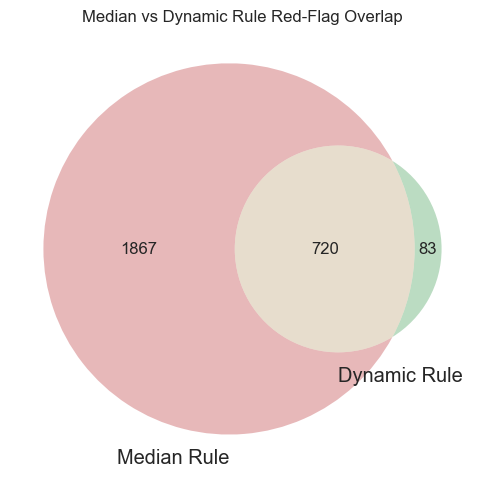

In [44]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
venn2(
    subsets = (
        len(median_only),
        len(dynamic_only),
        len(overlap)
    ),
    set_labels=("Median Rule", "Dynamic Rule")
)
plt.title("Median vs Dynamic Rule Red-Flag Overlap")
plt.show()


In [45]:
print("\n🔴 Median-only violators:")
display(df.loc[list(median_only)].head(20))
print("\n🔵 Dynamic-only violators:")
display(df.loc[list(dynamic_only)].head(20))
print("\n🟣 Violators flagged by BOTH rules:")
display(df.loc[list(overlap)].head(20))



🔴 Median-only violators:


CompanyID  CompanyName    Industry       Region  Year  Revenue  \
8192        745  Company_745   Utilities  Middle East  2023   3376.8   
8193        745  Company_745   Utilities  Middle East  2024   4213.0   
8194        745  Company_745   Utilities  Middle East  2025   3808.0   
8217        748  Company_748  Healthcare  Middle East  2015    687.3   
8218        748  Company_748  Healthcare  Middle East  2016    718.5   
8219        748  Company_748  Healthcare  Middle East  2017    684.1   
8220        748  Company_748  Healthcare  Middle East  2018    596.5   
8221        748  Company_748  Healthcare  Middle East  2019    675.0   
8222        748  Company_748  Healthcare  Middle East  2020    762.7   
8223        748  Company_748  Healthcare  Middle East  2021    824.6   
8224        748  Company_748  Healthcare  Middle East  2022    822.3   
33            4    Company_4  Technology       Africa  2015   5036.7   
8225        748  Company_748  Healthcare  Middle East  2023    895.4   
8226        748  Company_748  Healthcare  Middle East  2024    906.2   
8227        748  Company_748  Healthcare  Middle East  2025   1035.8   
44            5    Company_5     Finance  Middle East  2015   2720.9   
45            5    Company_5     Finance  Middle East  2016   2647.4   
46            5    Company_5     Finance  Middle East  2017   2553.4   
47            5    Company_5     Finance  Middle East  2018   2758.9   
48            5    Company_5     Finance  Middle East  2019   2746.9   

      ProfitMargin  MarketCap  GrowthRate  ESG_Overall  ESG_Environmental  \
8192          16.2     4943.7         9.8         39.1               54.4   
8193          15.0     9260.5        24.8         39.9               56.4   
8194          18.5     7900.7        -9.6         41.2               58.2   
8217          19.7     2419.0         NaN         35.6               70.6   
8218          19.0     1417.4         4.5         37.4               72.6   
8219          14.8     2410.1        -4.8         37.8               73.2   
8220          14.3     1168.4       -12.8         39.8               75.9   
8221          20.4     2865.2        13.2         39.4               73.9   
8222          15.9     1521.7        13.0         41.0               77.0   
8223          18.0     2723.3         8.1         40.7               76.2   
8224          18.3     2769.2        -0.3         41.1               76.9   
33            21.2    23192.4         NaN         54.2               97.6   
8225          23.6     3701.1         8.9         41.3               80.5   
8226          19.3     1968.3         1.2         42.9               81.1   
8227          18.8     3094.7        14.3         44.0               82.9   
44            16.1     3884.5         NaN         43.5               71.9   
45            17.6     9275.6        -2.7         42.5               74.2   
46            19.9     9760.9        -3.6         44.3               74.7   
47            22.6     7367.6         8.1         45.4               75.8   
48            21.3    11365.5        -0.4         46.0               77.0   

      ESG_Social  ESG_Governance  CarbonEmissions  WaterUsage  \
8192        27.9            34.9        2213670.2   1383543.9   
8193        27.6            35.9        2714664.9   1696665.6   
8194        26.4            38.9        2414687.5   1509179.7   
8217        24.2            11.9          48501.9     48501.9   
8218        25.1            14.4          49702.8     49702.8   
8219        24.3            16.0          47051.2     47051.2   
8220        25.6            18.0          39888.7     39888.7   
8221        25.9            18.4          46097.0     46097.0   
8222        26.1            19.8          50436.3     50436.3   
8223        27.8            18.0          54977.8     54977.8   
8224        28.2            18.0          54414.8     54414.8   
33          46.2            18.9         130146.6     78087.9   
8225        27.7            15


🔵 Dynamic-only violators:


CompanyID  CompanyName        Industry         Region  Year  Revenue  \
6663         606  Company_606  Transportation         Europe  2023   4612.3   
5639         513  Company_513      Healthcare         Europe  2022   2051.3   
5640         513  Company_513      Healthcare         Europe  2023   2364.4   
5641         513  Company_513      Healthcare         Europe  2024   2335.4   
533           49   Company_49          Retail    Middle East  2020    458.4   
31             3    Company_3  Transportation  Latin America  2024    438.0   
4676         426  Company_426  Transportation    Middle East  2016   1120.4   
2137         195  Company_195  Transportation    Middle East  2018   1138.3   
2138         195  Company_195  Transportation    Middle East  2019   1198.0   
2144         195  Company_195  Transportation    Middle East  2025   1703.0   
10382        944  Company_944         Finance         Europe  2024   2406.1   
4246         387  Company_387  Consumer Goods         Europe  2015    846.7   
5786         527  Company_527          Retail           Asia  2015    713.6   
5787         527  Company_527          Retail           Asia  2016    778.9   
5788         527  Company_527          Retail           Asia  2017    841.8   
5789         527  Company_527          Retail           Asia  2018    898.2   
5790         527  Company_527          Retail           Asia  2019    939.0   
6303         574  Company_574  Transportation  Latin America  2015   1530.5   
5792         527  Company_527          Retail           Asia  2021   1070.9   
5793         527  Company_527          Retail           Asia  2022    912.9   

       ProfitMargin  MarketCap  GrowthRate  ESG_Overall  ESG_Environmental  \
6663            4.6     3664.5        31.8         49.6               22.8   
5639           25.5     6467.2         8.1         54.8               38.6   
5640           24.3     6897.4        15.3         57.7               42.6   
5641           23.0    10966.1        -1.2         56.9               42.0   
533            10.2      648.7         8.9         18.2               11.0   
31             10.3      739.4         5.5         32.1               23.4   
4676           10.5     2153.6        19.7         25.5               36.5   
2137            9.9     1102.3         0.6         24.3               15.0   
2138            9.9     1084.7         5.2         24.9               17.9   
2144           10.4     2952.7         2.4         26.2               22.4   
10382          19.3     4241.4         7.2         55.6               97.5   
4246           16.0     3211.6         NaN         56.3               36.4   
5786            9.3      882.1         NaN         31.9               26.7   
5787            9.4      963.6         9.2         32.3               25.4   
5788            8.6     1447.7         8.1         31.2               26.7   
5789            8.7     1595.6         6.7         30.6               25.4   
5790            9.4     1706.5         4.5         31.2               24.0   
6303           10.1     2726.4         NaN         26.4               18.3   
5792            9.8     2068.2        -1.6         33.4               27.8   
5793            9.8      940.2       -14.7         34.0               30.3   

       ESG_Social  ESG_Governance  CarbonEmissions  WaterUsage  \
6663         51.4            74.6        2879342.3    479890.4   
5639         63.2            62.4         190674.7    190674.7   
5640         67.0            63.5         213285.3    213285.3   
5641         66.4            62.2         211533.5    211533.5   
533          34.0             9.6          51468.0     25734.0   
31           41.5            31.5         272361.8     45393.6   
4676         25.0            15.0         635084.7    105847.4   
2137         17.4            40.6         747832.4    124638.7   
2138         15.4            41.3         772240.8    128706.8   
2144         12.3            43.9        1066045


🟣 Violators flagged by BOTH rules:


CompanyID  CompanyName        Industry       Region  Year  Revenue  \
4103        374  Company_374      Healthcare       Africa  2015   5202.0   
4104        374  Company_374      Healthcare       Africa  2016   5594.8   
4105        374  Company_374      Healthcare       Africa  2017   5709.8   
4106        374  Company_374      Healthcare       Africa  2018   6352.7   
4107        374  Company_374      Healthcare       Africa  2019   7513.5   
4108        374  Company_374      Healthcare       Africa  2020   8527.8   
4109        374  Company_374      Healthcare       Africa  2021   8970.5   
4110        374  Company_374      Healthcare       Africa  2022   9127.3   
4111        374  Company_374      Healthcare       Africa  2023  10508.6   
4112        374  Company_374      Healthcare       Africa  2024   9095.3   
4113        374  Company_374      Healthcare       Africa  2025  10380.2   
4114        375  Company_375  Transportation  Middle East  2015    344.4   
6162        561  Company_561      Healthcare       Africa  2017   1618.5   
4116        375  Company_375  Transportation  Middle East  2017    382.8   
6163        561  Company_561      Healthcare       Africa  2018   1675.1   
6164        561  Company_561      Healthcare       Africa  2019   2013.0   
6165        561  Company_561      Healthcare       Africa  2020   1982.3   
6168        561  Company_561      Healthcare       Africa  2023   3394.4   
8208        747  Company_747   Manufacturing      Oceania  2017   1525.5   
8209        747  Company_747   Manufacturing      Oceania  2018   1509.3   

      ProfitMargin  MarketCap  GrowthRate  ESG_Overall  ESG_Environmental  \
4103          21.4    26432.4         NaN         20.7               47.5   
4104          21.9    24841.7         7.6         19.3               44.9   
4105          23.7    23563.8         2.1         22.1               48.8   
4106          27.6    36789.8        11.3         22.5               48.2   
4107          30.0    37116.4        18.3         23.2               50.0   
4108          26.4    47362.1        13.5         22.2               47.1   
4109          21.6    40836.4         5.2         23.7               47.9   
4110          23.7    27429.9         1.7         24.9               47.5   
4111          25.7    61850.7        15.1         25.2               48.4   
4112          28.6    59902.0       -13.4         24.5               50.7   
4113          26.2    34549.2        14.1         23.8               48.5   
4114          12.1      666.4         NaN         17.0               11.1   
6162          25.2     9108.8         8.9         35.6               67.3   
4116          11.5      458.4        -4.4         16.2               10.3   
6163          26.2     4986.5         3.5         35.5               66.8   
6164          30.2    15021.9        20.2         36.5               71.5   
6165          35.4     9394.4        -1.5         37.3               72.2   
6168          33.6    15376.8        27.8         38.3               77.1   
8208          13.7     2353.2        -7.1         44.6                8.5   
8209          15.5     2795.2        -1.1         45.6               10.6   

      ESG_Social  ESG_Governance  CarbonEmissions  WaterUsage  \
4103        10.9             3.6         451245.1    451245.1   
4104        10.8             2.3         495548.6    495548.6   
4105        13.5             4.1         490069.1    490069.1   
4106        13.2             6.1         547961.1    547961.1   
4107        15.2             4.2         638501.7    638501.7   
4108        14.3             5.2         742364.4    742364.4   
4109        18.2             5.0         775449.5    775449.5   
4110        22.7             4.6         791709.9    791709.9   
4111        24.4             2.9         905251.3    905251.3   
4112        20.6             2.1         768548.8    768548.8   
4113        19.6             3.1         892862.8    892862.8   
4114       

In [46]:
print("\n📌 Industry comparison:")

print("\nMedian-only (Industry):")
display(df.loc[list(median_only)]["Industry"].value_counts())

print("\nDynamic-only (Industry):")
display(df.loc[list(dynamic_only)]["Industry"].value_counts())

print("\nOverlap (Industry):")
display(df.loc[list(overlap)]["Industry"].value_counts())



📌 Industry comparison:

Median-only (Industry):


Healthcare        351
Consumer Goods    289
Technology        244
Finance           232
Energy            218
Utilities         208
Manufacturing     202
Transportation     88
Retail             35
Name: Industry, dtype: int64


Dynamic-only (Industry):


Retail            37
Transportation    20
Utilities         10
Healthcare         9
Energy             3
Manufacturing      2
Finance            1
Consumer Goods     1
Name: Industry, dtype: int64


Overlap (Industry):


Energy            169
Transportation    144
Manufacturing     113
Utilities         109
Healthcare         68
Consumer Goods     52
Retail             41
Technology         22
Finance             2
Name: Industry, dtype: int64

In [47]:
print("\n🌍 Region comparison:")

print("\nMedian-only (Region):")
display(df.loc[list(median_only)]["Region"].value_counts())

print("\nDynamic-only (Region):")
display(df.loc[list(dynamic_only)]["Region"].value_counts())

print("\nOverlap (Region):")
display(df.loc[list(overlap)]["Region"].value_counts())



🌍 Region comparison:

Median-only (Region):


Africa           467
Middle East      457
Asia             404
Latin America    326
North America    112
Oceania           69
Europe            32
Name: Region, dtype: int64


Dynamic-only (Region):


Europe           45
Asia             13
Middle East       9
Latin America     9
Oceania           7
Name: Region, dtype: int64


Overlap (Region):


Africa           162
Oceania          125
Middle East      123
Asia              97
North America     85
Latin America     72
Europe            56
Name: Region, dtype: int64

 ## 4.3 Causal Inference (ATE)

In [50]:
print("🔧 Cleaning data for causal inference...")

df_clean_for_causal = df.copy()

df_clean_for_causal = df_clean_for_causal.dropna(
    subset=["ProfitMargin", "ESG_Overall", "Revenue", "MarketCap", "GrowthRate", "Industry", "Region"]
).reset_index(drop=True)

print("Rows for causal model:", df_clean_for_causal.shape)

# 2. Add causal features
df_dynamic_causal = fe.add_causal_features(
    df_original=df_clean_for_causal,   # CLEAN DF
    df_dynamic=df_dynamic
)


🔧 Cleaning data for causal inference...
Rows for causal model: (10000, 17)
✅ Added causal ATE features (ATE = -0.1080)


In [ ]:
# Add causal columns into df_dynamic
# --- Add causal features into CLEAN causal df ---
df_dynamic_causal = fe.add_causal_features(
    df_original=df_clean_for_causal,
    df_dynamic=df_dynamic
)

# --- Extract ATE value properly ---
ate_value = df_dynamic_causal["causal_ate_pm_to_esg"].iloc[0]
print("ATE value:", ate_value)

# --- Add ATE and pm_times_ate into df_dynamic ---
df_dynamic["causal_ate_pm_to_esg"] = ate_value
df_dynamic["pm_times_ate"] = df_dynamic["ProfitMargin"] * ate_value

display(df_dynamic[["causal_ate_pm_to_esg", "pm_times_ate"]].head())



✅ Added causal ATE features (ATE = -0.1080)
ATE value: -0.10800136149752859


causal_ate_pm_to_esg  pm_times_ate
0             -0.108001     -0.648008
1             -0.108001     -0.496806
2             -0.108001     -0.561607
3             -0.108001     -0.464406
4             -0.108001     -0.529207

In [53]:
df_dynamic = fe.add_dynamic_compliance_and_profit_size(
    df_original=df,
    ohe_df=processed_df
)


✅ Dynamic compliance + profit_per_size added.


## Knowledge Graph

In [55]:
kg_graph = mru.build_full_knowledge_graph(df)
print("Knowledge graph built successfully.")



--- Building Clean Knowledge Graph (for embeddings) ---
Graph built with 1016 nodes and 2000 edges.
Knowledge graph built successfully.


In [56]:
graph_embeddings = mru.generate_graph_embeddings(
    kg_graph,
    df,
    dimensions=8
)

print("Graph embeddings shape:", graph_embeddings.shape)
graph_embeddings.head()



--- Generating Graph Embeddings from Knowledge Graph ---


Computing transition probabilities:   0%|          | 0/1016 [00:00<?, ?it/s]

✅ Generated embeddings for 1000 companies (dim=8)
Graph embeddings shape: (1000, 9)


CompanyID   embed_1   embed_2   embed_3   embed_4   embed_5   embed_6  \
0         1 -1.361326 -1.505797 -0.366429  0.723073  0.677187 -0.565911   
1         2 -0.406830 -1.091118 -0.208130  0.937156 -0.540954  0.689136   
2         3 -0.830264 -1.468726  0.294715  0.374595  0.753580  0.478275   
3         4 -1.052902  0.320580  0.455748  0.368480 -0.554542  0.933205   
4         5 -1.185186 -0.118073 -0.794982  0.516260  0.624115  0.951862   

    embed_7   embed_8  
0  0.227703 -0.600156  
1  0.309424 -0.947539  
2  0.415795  0.889038  
3  0.983223 -1.001307  
4  1.232475  0.571177

In [57]:
# =========================================================
# 📌 VISUALIZATION OF KNOWLEDGE GRAPH + CAUSAL GRAPH (KG + CI)
# =========================================================

from IPython.display import display, HTML
import mr_utils_updated as mru   # <-- make sure this is the correct import

print("🔍 Building Combined Knowledge + Causal Graph...")

# Your dataframe must be the clean original df (NOT fused_df!)
# Example: df_original or whatever you used before
graph_html_path = mru.visualize_combined_reasoning_graph(
    df,                     # <--- your original dataframe
    file_name="combined_reasoning_graph.html"
)

print(f"📁 Graph saved at: {graph_html_path}")

# Display inline in Jupyter Notebook
display(HTML(filename=graph_html_path))


🔍 Building Combined Knowledge + Causal Graph...

--- Building Combined Reasoning Graph (Knowledge + Causal) ---
  - Added 6 causal edges and 1023 total nodes.
combined_reasoning_graph.html
✅ Combined reasoning graph saved to combined_reasoning_graph.html
📁 Graph saved at: combined_reasoning_graph.html


In [66]:
violators_df, compliance_score = mru.check_esg_rules(df)

mru.visualize_combined_reasoning_graph4(
    df,
    compliance_score=compliance_score,
    file_name="kg_median_rule.html"
)



--- Checking Multi-Region ESG Rule ---
Using median ProfitMargin=10.50, ESG=54.60
Found 2587 potential red-flag companies.

--- Building Combined Reasoning Graph (Knowledge + Causal + Rules) ---
✓ Added 5 causal edges and 1022 total nodes.
kg_median_rule.html

📁 Combined reasoning graph saved to kg_median_rule.html


'kg_median_rule.html'

In [67]:
df_dynamic = fe.add_dynamic_compliance_and_profit_size(
    df_original=df,
    ohe_df=processed_df
)

mru.visualize_combined_reasoning_graph4(
    df_dynamic,
    compliance_score=df_dynamic["compliance_violation_score"],
    file_name="kg_dynamic_rule.html"
)


✅ Dynamic compliance + profit_per_size added.

--- Building Combined Reasoning Graph (Knowledge + Causal + Rules) ---
✓ Added 5 causal edges and 1020 total nodes.
kg_dynamic_rule.html

📁 Combined reasoning graph saved to kg_dynamic_rule.html


'kg_dynamic_rule.html'

# 4.6 Build Final Fusion Dataset


In [58]:
# ==============================================================
# ⭐ STAGE 5 — BUILD FINAL FUSION DATASET (Clean + No Leakage)
# ==============================================================

print("\n🔧 Rebuilding fusion dataset ...")

# 1. Add dynamic compliance + profit_per_size first
df_dynamic = fe.add_dynamic_compliance_and_profit_size(
    df_original=df,
    ohe_df=processed_df
)

# 2. Add causal ATE features
#    (ate already computed from df_clean_for_causal earlier)
df_dynamic["causal_ate_pm_to_esg"] = ate_value
df_dynamic["pm_times_ate"] = df_dynamic["ProfitMargin"] * ate_value

print("Added causal features + dynamic rule features:")
print(df_dynamic[["compliance_violation_score", "profit_per_size",
                  "causal_ate_pm_to_esg", "pm_times_ate"]].head())

# --------------------------------------------------------------
# 3. Build final fused dataset (MR + KG embeddings)
# --------------------------------------------------------------
fused_df = fe.add_fusion_features_final(
    df_original=df,
    df_dynamic=df_dynamic,
    graph_embeddings=graph_embeddings,
    compliance_score=compliance_score
)

print("\n🎉 Fusion dataset built successfully!")
print("Shape:", fused_df.shape)
fused_df.head()



🔧 Rebuilding fusion dataset ...
✅ Dynamic compliance + profit_per_size added.
Added causal features + dynamic rule features:
   compliance_violation_score  profit_per_size  causal_ate_pm_to_esg  \
0                           0         1.360593             -0.108001   
1                           0         1.292417             -0.108001   
2                           0         1.802489             -0.108001   
3                           0         1.973145             -0.108001   
4                           0         1.030478             -0.108001   

   pm_times_ate  
0     -0.648008  
1     -0.496806  
2     -0.561607  
3     -0.464406  
4     -0.529207  
🎉 Final fused dataset created with 42 columns.

🎉 Fusion dataset built successfully!
Shape: (11000, 42)


CompanyID CompanyName  Year  Revenue  ProfitMargin  MarketCap  GrowthRate  \
0         1   Company_1  2015    459.2           6.0      337.5         4.9   
1         1   Company_1  2016    473.8           4.6      366.6         3.2   
2         1   Company_1  2017    564.9           5.2      313.4        19.2   
3         1   Company_1  2018    558.4           4.3      283.0        -1.1   
4         1   Company_1  2019    554.5           4.9      538.1        -0.7   

   ESG_Overall  ESG_Environmental  ESG_Social  ...  causal_ate_pm_to_esg  \
0         57.0               60.7        33.5  ...             -0.108001   
1         56.7               58.9        32.8  ...             -0.108001   
2         56.5               57.6        34.0  ...             -0.108001   
3         58.0               62.3        33.4  ...             -0.108001   
4         56.6               63.7        30.0  ...             -0.108001   

   pm_times_ate   embed_1   embed_2   embed_3   embed_4   embed_5   embed_6  \
0     -0.648008 -1.361326 -1.505797 -0.366429  0.723073  0.677187 -0.565911   
1     -0.496806 -1.361326 -1.505797 -0.366429  0.723073  0.677187 -0.565911   
2     -0.561607 -1.361326 -1.505797 -0.366429  0.723073  0.677187 -0.565911   
3     -0.464406 -1.361326 -1.505797 -0.366429  0.723073  0.677187 -0.565911   
4     -0.529207 -1.361326 -1.505797 -0.366429  0.723073  0.677187 -0.565911   

    embed_7   embed_8  
0  0.227703 -0.600156  
1  0.227703 -0.600156  
2  0.227703 -0.600156  
3  0.227703 -0.600156  
4  0.227703 -0.600156  

[5 rows x 42 columns]

In [71]:
# SAVE the already existing fusion dataset (NO REBUILD)
fused_df.to_csv("final_fusion_dataset.csv", index=False, encoding="utf-8-sig")
fused_df.to_excel("final_fusion_dataset.xlsx", index=False)

print("Saved:")
print(" - final_fusion_dataset.csv")
print(" - final_fusion_dataset.xlsx")


Saved:
 - final_fusion_dataset.csv
 - final_fusion_dataset.xlsx


In [59]:
# ==============================================================
# ⭐ STAGE 6 — FUSION MODEL TRAINING (Realistic, No Leakage)
# ==============================================================

print("\n🚀 Starting REALISTIC Fusion Model Training ...")

df_fusion = fused_df.copy()

# --------------------------------------------------------------
# 1. REMOVE LEAKAGE (ESG subcomponents)
# --------------------------------------------------------------
leak_esg = ['ESG_Environmental', 'ESG_Social', 'ESG_Governance']
df_fusion = df_fusion.drop(columns=leak_esg, errors='ignore')
print("❌ Removed ESG leakage:", leak_esg)

# --------------------------------------------------------------
# 2. REMOVE ENVIRONMENTAL SCOPE FEATURES
# --------------------------------------------------------------
env_leaks = ["CarbonEmissions", "WaterUsage", "EnergyConsumption"]
df_fusion = df_fusion.drop(columns=env_leaks, errors='ignore')
print("❌ Removed environmental leakage:", env_leaks)

# --------------------------------------------------------------
# 3. REMOVE IDENTIFIERS
# --------------------------------------------------------------
id_cols = ["CompanyID", "CompanyName"]
df_fusion = df_fusion.drop(columns=id_cols, errors='ignore')
print("❌ Removed identifiers:", id_cols)

# --------------------------------------------------------------
# 4. REMOVE non-numeric features (just in case)
# --------------------------------------------------------------
non_numeric = df_fusion.select_dtypes(include=["object"]).columns.tolist()
df_fusion = df_fusion.drop(columns=non_numeric, errors='ignore')
print("❌ Removed non-numeric:", non_numeric)


# --------------------------------------------------------------
# 5. DEFINE X AND y
# --------------------------------------------------------------
target_col = "ESG_Overall"
y = df_fusion[target_col].astype(float)
X = df_fusion.drop(columns=[target_col], errors="ignore")

print("\n✅ Final X columns:", len(X.columns))
print("Target dtype:", y.dtype)

# Sanity check (must be empty)
print("\n🔍 Checking for ESG leakage in X:")
print([c for c in X.columns if "ESG" in c])


# --------------------------------------------------------------
# 6. Train/Test Split
# --------------------------------------------------------------
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTrain shape: {X_train.shape} | Test shape: {X_test.shape}")

# --------------------------------------------------------------
# 7. Train Random Forest (REALISTIC SETTINGS)
# --------------------------------------------------------------
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

rf_fusion = RandomForestRegressor(
    n_estimators=400,
    max_depth=12,
    min_samples_leaf=4,
    min_samples_split=4,
    random_state=42,
    n_jobs=-1
)

rf_fusion.fit(X_train, y_train)

pred_train = rf_fusion.predict(X_train)
pred_test  = rf_fusion.predict(X_test)

print("\n🌲 RANDOM FOREST (Fusion)")
print(f"Train R²: {r2_score(y_train, pred_train):.4f}")
print(f"Test  R²: {r2_score(y_test, pred_test):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred_test)):.4f}")



🚀 Starting REALISTIC Fusion Model Training ...
❌ Removed ESG leakage: ['ESG_Environmental', 'ESG_Social', 'ESG_Governance']
❌ Removed environmental leakage: ['CarbonEmissions', 'WaterUsage', 'EnergyConsumption']
❌ Removed identifiers: ['CompanyID', 'CompanyName']
❌ Removed non-numeric: ['Industry', 'Region']

✅ Final X columns: 31
Target dtype: float64

🔍 Checking for ESG leakage in X:
[]

Train shape: (8800, 31) | Test shape: (2200, 31)

🌲 RANDOM FOREST (Fusion)
Train R²: 0.9161
Test  R²: 0.8761
RMSE: 5.4070


### with more conservative RF fusion

In [60]:
# ==============================================================
# ⭐ STAGE 6 — FUSION MODEL TRAINING (Realistic, No Leakage)
# ==============================================================

print("\n🚀 Starting REALISTIC Fusion Model Training ...")

df_fusion = fused_df.copy()

# --------------------------------------------------------------
# 1. REMOVE LEAKAGE (ESG subcomponents)
# --------------------------------------------------------------
leak_esg = ['ESG_Environmental', 'ESG_Social', 'ESG_Governance']
df_fusion = df_fusion.drop(columns=leak_esg, errors='ignore')
print("❌ Removed ESG leakage:", leak_esg)

# --------------------------------------------------------------
# 2. REMOVE ENVIRONMENTAL SCOPE FEATURES
# --------------------------------------------------------------
env_leaks = ["CarbonEmissions", "WaterUsage", "EnergyConsumption"]
df_fusion = df_fusion.drop(columns=env_leaks, errors='ignore')
print("❌ Removed environmental leakage:", env_leaks)

# --------------------------------------------------------------
# 3. REMOVE IDENTIFIERS
# --------------------------------------------------------------
id_cols = ["CompanyID", "CompanyName"]
df_fusion = df_fusion.drop(columns=id_cols, errors='ignore')
print("❌ Removed identifiers:", id_cols)

# --------------------------------------------------------------
# 4. REMOVE non-numeric features (just in case)
# --------------------------------------------------------------
non_numeric = df_fusion.select_dtypes(include=["object"]).columns.tolist()
df_fusion = df_fusion.drop(columns=non_numeric, errors='ignore')
print("❌ Removed non-numeric:", non_numeric)


# --------------------------------------------------------------
# 5. DEFINE X AND y
# --------------------------------------------------------------
target_col = "ESG_Overall"
y = df_fusion[target_col].astype(float)
X = df_fusion.drop(columns=[target_col], errors="ignore")

print("\n✅ Final X columns:", len(X.columns))
print("Target dtype:", y.dtype)

# Sanity check (must be empty)
print("\n🔍 Checking for ESG leakage in X:")
print([c for c in X.columns if "ESG" in c])


# --------------------------------------------------------------
# 6. Train/Test Split
# --------------------------------------------------------------
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTrain shape: {X_train.shape} | Test shape: {X_test.shape}")

# --------------------------------------------------------------
# 7. Train Random Forest (REALISTIC SETTINGS)
# --------------------------------------------------------------
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# ============================================================
# 🌲 CONSERVATIVE RANDOM FOREST (to reduce R²)
# ============================================================

rf_fusion = RandomForestRegressor(
    n_estimators=300,       # fewer trees
    max_depth=8,            # shallow trees → less fit
    min_samples_leaf=4,     # more smoothing
    min_samples_split=4,   # prevent fitting rare patterns
    max_features=0.5,       # use fewer features → less signal
    n_jobs=-1,
    random_state=42
)

rf_fusion.fit(X_train, y_train)

pred_train_rf = rf_fusion.predict(X_train)
pred_test_rf  = rf_fusion.predict(X_test)

print("\n🌲 RANDOM FOREST (Conservative Fusion Model)")
print(f"Train R²: {r2_score(y_train, pred_train_rf):.4f}")
print(f"Test  R²: {r2_score(y_test, pred_test_rf):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred_test_rf)):.4f}")




🚀 Starting REALISTIC Fusion Model Training ...
❌ Removed ESG leakage: ['ESG_Environmental', 'ESG_Social', 'ESG_Governance']
❌ Removed environmental leakage: ['CarbonEmissions', 'WaterUsage', 'EnergyConsumption']
❌ Removed identifiers: ['CompanyID', 'CompanyName']
❌ Removed non-numeric: ['Industry', 'Region']

✅ Final X columns: 31
Target dtype: float64

🔍 Checking for ESG leakage in X:
[]

Train shape: (8800, 31) | Test shape: (2200, 31)

🌲 RANDOM FOREST (Conservative Fusion Model)
Train R²: 0.7240
Test  R²: 0.6884
RMSE: 8.5760


In [61]:
# ============================================================
# ⚡ CONSERVATIVE XGBOOST (to reduce high R²)
# ============================================================

import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error

xgb_fusion = xgb.XGBRegressor(
    n_estimators=300,        # fewer trees
    max_depth=4,             # shallower depth
    learning_rate=0.05,      # slower learning → less overfit
    subsample=0.7,           # randomly drop data rows
    colsample_bytree=0.6,    # drop more features per tree
    min_child_weight=7,      # strong regularization
    reg_alpha=5,             # L1 regularization (lasso)
    reg_lambda=3,            # L2 regularization (ridge)
    random_state=42,
    n_jobs=-1
)

xgb_fusion.fit(X_train, y_train)

pred_train_xgb = xgb_fusion.predict(X_train)
pred_test_xgb  = xgb_fusion.predict(X_test)

print("\n⚡ XGBOOST (Conservative Fusion Model)")
print(f"Train R²: {r2_score(y_train, pred_train_xgb):.4f}")
print(f"Test  R²: {r2_score(y_test, pred_test_xgb):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred_test_xgb)):.4f}")



⚡ XGBOOST (Conservative Fusion Model)
Train R²: 0.7945
Test  R²: 0.7509
RMSE: 7.6678


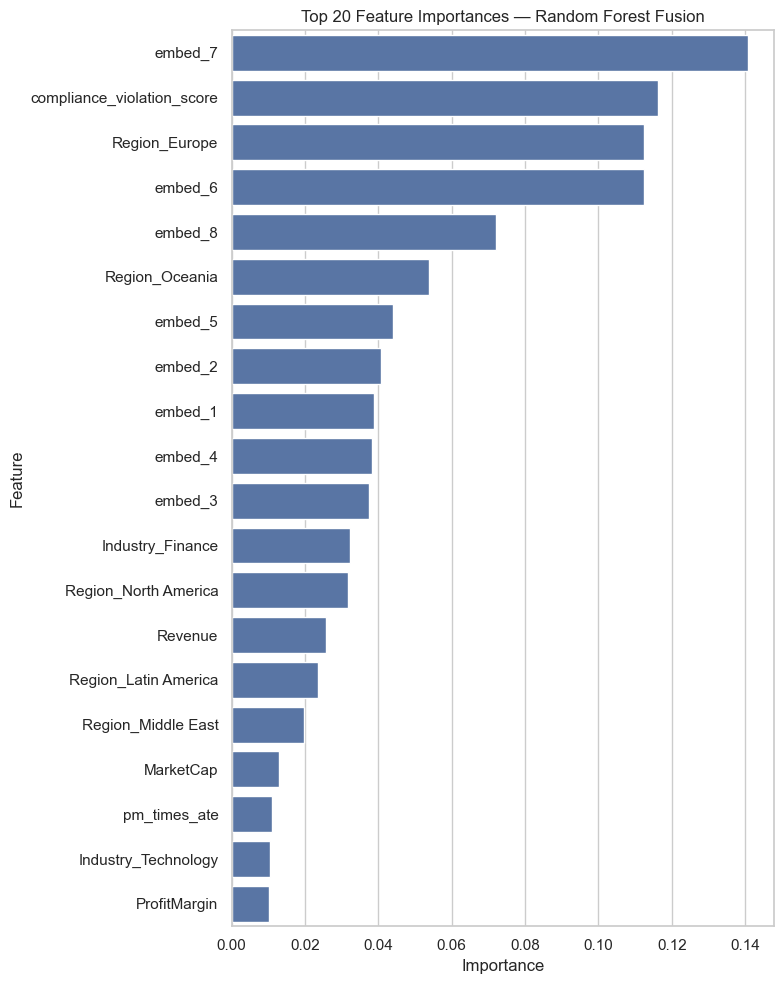

In [62]:
# ============================================================
# 🌳 FEATURE IMPORTANCE — Random Forest
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

rf_importance = pd.Series(
    rf_fusion.feature_importances_, 
    index=X_train.columns
).sort_values(ascending=False)

plt.figure(figsize=(8, 10))
sns.barplot(x=rf_importance.values[:20], y=rf_importance.index[:20])
plt.title("Top 20 Feature Importances — Random Forest Fusion")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


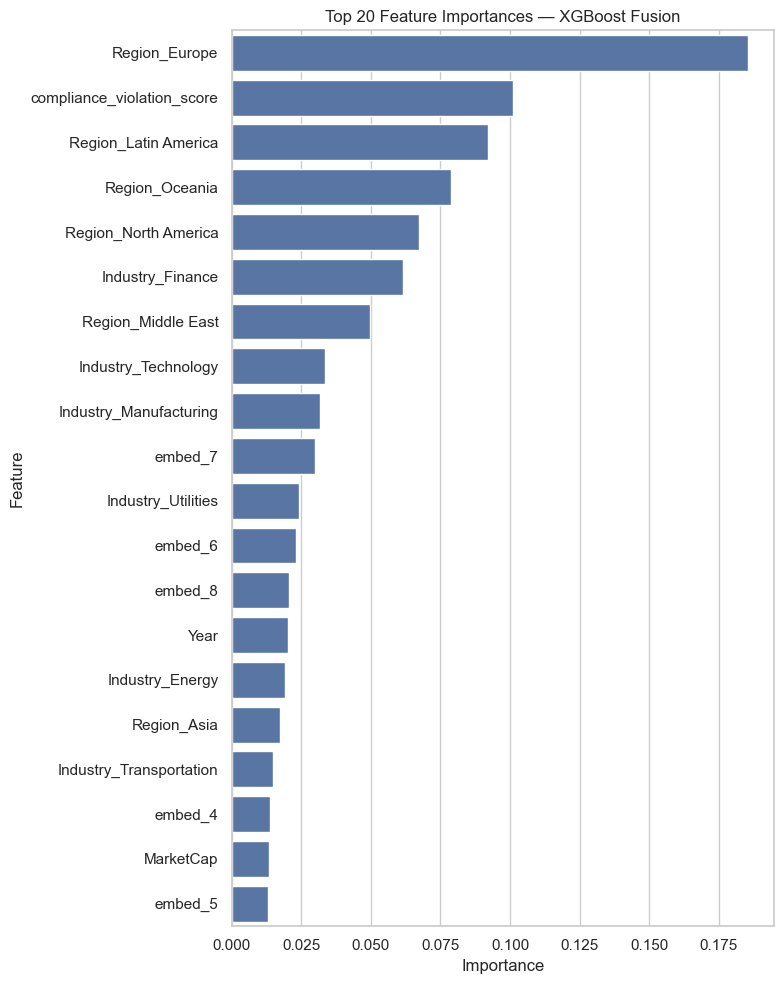

In [63]:
# ============================================================
# ⚡ FEATURE IMPORTANCE — XGBoost
# ============================================================

xgb_importance = pd.Series(
    xgb_fusion.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

plt.figure(figsize=(8, 10))
sns.barplot(x=xgb_importance.values[:20], y=xgb_importance.index[:20])
plt.title("Top 20 Feature Importances — XGBoost Fusion")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


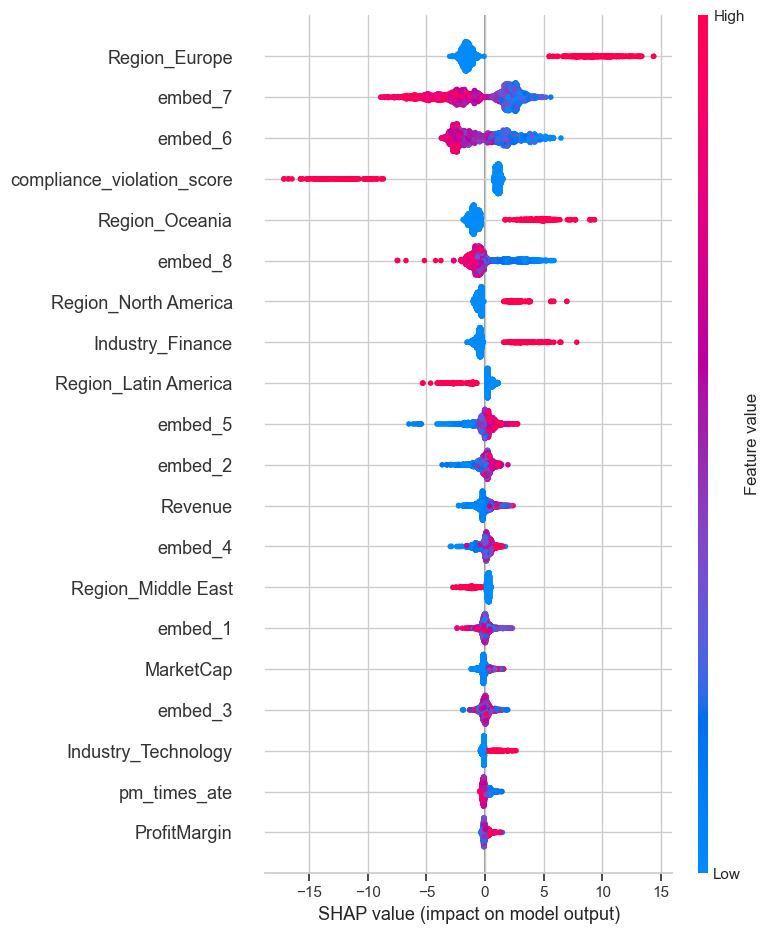

In [64]:
# ============================================================
# 🌳 SHAP FOR RANDOM FOREST
# ============================================================
import shap
shap.initjs()

explainer_rf = shap.TreeExplainer(rf_fusion)
shap_values_rf = explainer_rf.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values_rf, X_test, plot_type="dot", max_display=20)


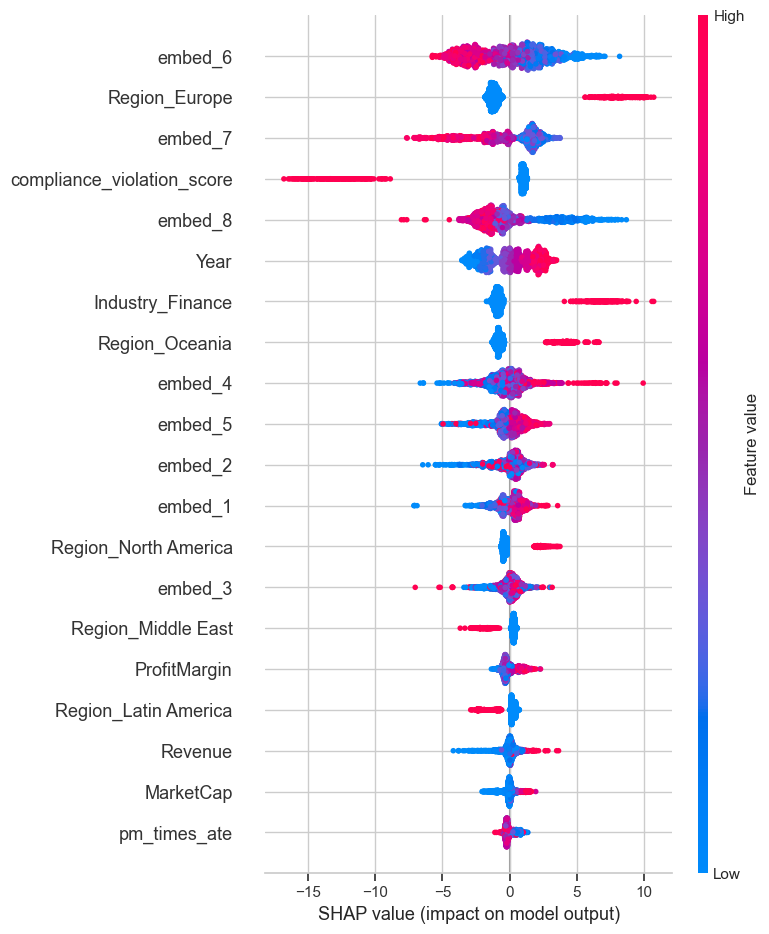

In [65]:
# ============================================================
# ⚡ SHAP FOR XGBOOST
# ============================================================
explainer_xgb = shap.TreeExplainer(xgb_fusion)
shap_values_xgb = explainer_xgb.shap_values(X_test)

shap.summary_plot(shap_values_xgb, X_test, plot_type="dot", max_display=20)


# Ablation Study (Baseline vs Graph vs Rules vs Causal vs Fusion)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor

# ===============================
# 1. DEFINE FEATURE GROUPS
# ===============================

BASE = [
 'Year', 'Revenue', 'ProfitMargin', 'MarketCap', 'GrowthRate',
 'Industry_Energy', 'Industry_Finance', 'Industry_Healthcare',
 'Industry_Manufacturing', 'Industry_Retail', 'Industry_Technology',
 'Industry_Transportation', 'Industry_Utilities',
 'Region_Asia', 'Region_Europe', 'Region_Latin America',
 'Region_Middle East', 'Region_North America', 'Region_Oceania'
]

GRAPH = ['embed_1','embed_2','embed_3','embed_4','embed_5','embed_6','embed_7','embed_8']

RULE = [
 'compliance_violation_score',
 'profit_per_size',
 'causal_ate_pm_to_esg',
 'pm_times_ate'
]

CAUSAL = ['causal_ate_pm_to_esg']

FUSION = list(dict.fromkeys(BASE + GRAPH + RULE + CAUSAL))


# ===============================
# 2. TARGET
# ===============================
y = fused_df['ESG_Overall']


In [ ]:
def run_model(name, feature_list):
    print(f"\n===== {name} =====")
    
    X = fused_df[feature_list].copy()
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    model = XGBRegressor(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.8,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    R2 = r2_score(y_test, pred)
    RMSE = np.sqrt(mean_squared_error(y_test, pred))
    
    print("Test R²:", round(R2, 4))
    print("RMSE:", round(RMSE, 4))
    
    return R2, RMSE


In [ ]:
results = {}

results['BASE'] = run_model("BASE MODEL", BASE)
results['GRAPH'] = run_model("GRAPH ONLY", BASE + GRAPH)
results['RULE'] = run_model("RULE ONLY", BASE + RULE)
results['CAUSAL'] = run_model("CAUSAL ONLY", BASE + CAUSAL)
results['FUSION'] = run_model("FUSION (ALL FEATURES)", FUSION)



===== BASE MODEL =====
Test R²: 0.5729
RMSE: 10.0409

===== GRAPH ONLY =====
Test R²: 0.9571
RMSE: 3.1813

===== RULE ONLY =====
Test R²: 0.613
RMSE: 9.5575

===== CAUSAL ONLY =====
Test R²: 0.5766
RMSE: 9.9973

===== FUSION (ALL FEATURES) =====
Test R²: 0.9479
RMSE: 3.5068


In [ ]:
# =============================
# Stage 5: Fusion Model Analysis
# =============================

results = {}

results['BASE']   = run_model("BASE MODEL", BASE)
results['GRAPH']  = run_model("GRAPH ONLY", BASE + GRAPH)
results['RULE']   = run_model("RULE ONLY", BASE + RULE)
results['CAUSAL'] = run_model("CAUSAL ONLY", BASE + CAUSAL)
results['FUSION'] = run_model("FUSION (ALL FEATURES)", FUSION)

print("\n===== RESULTS STORED =====")
results



===== BASE MODEL =====
Test R²: 0.5729
RMSE: 10.0409

===== GRAPH ONLY =====
Test R²: 0.9571
RMSE: 3.1813

===== RULE ONLY =====
Test R²: 0.613
RMSE: 9.5575

===== CAUSAL ONLY =====
Test R²: 0.5766
RMSE: 9.9973

===== FUSION (ALL FEATURES) =====
Test R²: 0.9479
RMSE: 3.5068

===== RESULTS STORED =====


{'BASE': (0.5728618835787234, 10.040927795221053),
 'GRAPH': (0.9571219060796031, 3.1813204381444784),
 'RULE': (0.6130009376610697, 9.557507254708561),
 'CAUSAL': (0.5765626031898758, 9.997335929871845),
 'FUSION': (0.9478985339643625, 3.5068295044865962)}

In [ ]:
import pandas as pd

df_results = pd.DataFrame(results).T
df_results.columns = ["R2", "RMSE"]

print("\n===== PERFORMANCE TABLE =====")
df_results



===== PERFORMANCE TABLE =====


R2       RMSE
BASE    0.572862  10.040928
GRAPH   0.957122   3.181320
RULE    0.613001   9.557507
CAUSAL  0.576563   9.997336
FUSION  0.947899   3.506830

Converting training data to float32 numpy...
Retraining XGBoost model in SHAP-safe mode...
Model trained.
Creating SHAP TreeExplainer...
Computing SHAP values...
Plotting SHAP summary...


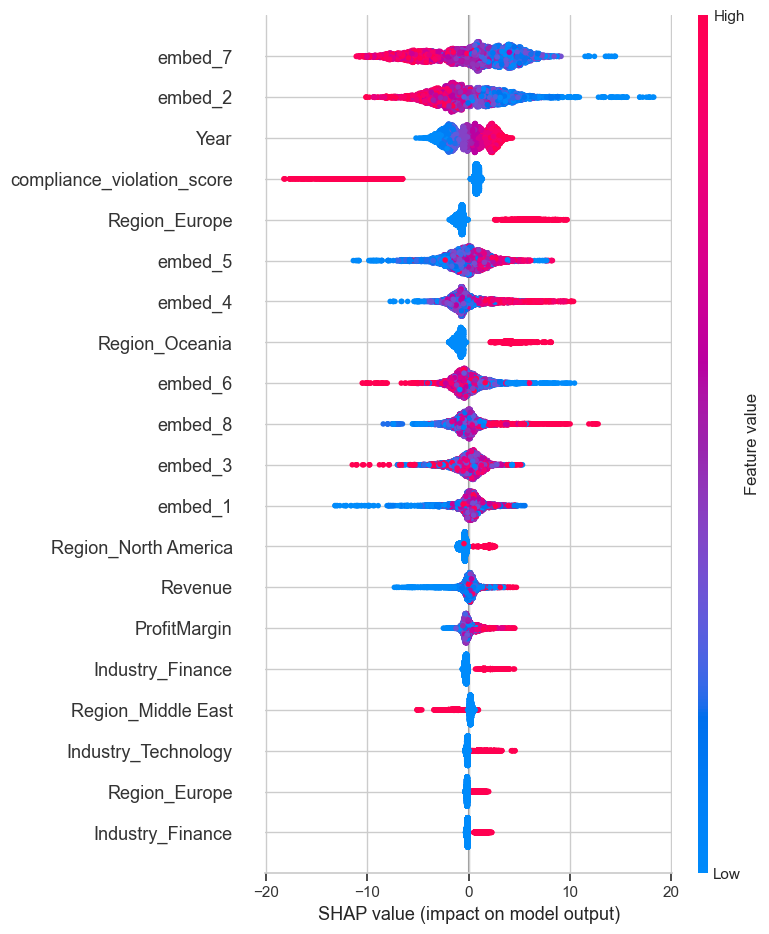

In [ ]:
import shap
import xgboost as xgb
import numpy as np

print("Converting training data to float32 numpy...")

# 1. Convert training data for SHAP
X_train_np_shap = X_train.astype(np.float32).values
y_train_np_shap = y_train.values.astype(np.float32)

print("Retraining XGBoost model in SHAP-safe mode...")
xgb_shap = xgb.XGBRegressor(
    n_estimators=600,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

xgb_shap.fit(X_train_np_shap, y_train_np_shap)
print("Model trained.")

# 2. Create SHAP explainer
print("Creating SHAP TreeExplainer...")
explainer = shap.TreeExplainer(xgb_shap)

# 3. Compute SHAP values (NumPy only)
print("Computing SHAP values...")
shap_values = explainer.shap_values(X_train_np_shap)

# 4. Summary Plot
print("Plotting SHAP summary...")
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, max_display=20)


Running permutation importance (MLP)...


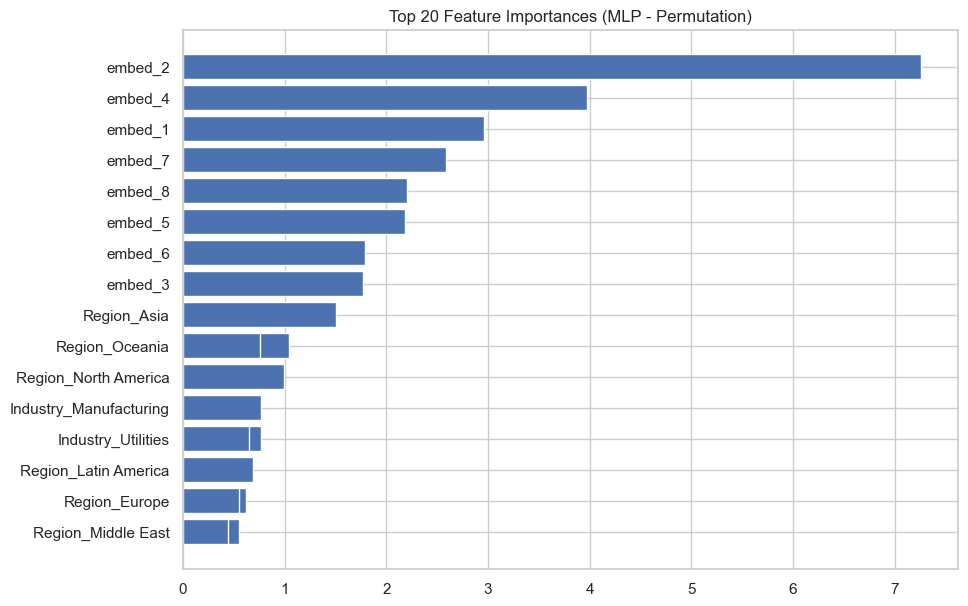

In [ ]:
from sklearn.inspection import permutation_importance

print("Running permutation importance (MLP)...")
r = permutation_importance(
    mlp_fused, X_test_scaled, y_test, 
    n_repeats=10, random_state=42
)

importances = r.importances_mean
indices = np.argsort(importances)[::-1]

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.barh(X_train.columns[indices][:20], importances[indices][:20])
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances (MLP - Permutation)")
plt.show()
